In [3]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from glob import glob

from sklearn import mixture

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from obiwan.common import fits2pandas

In [5]:
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)


In [405]:
def my_mixture(X,n_comp=None,cov_type='full'):
    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    if n_comp is None:
        n_comp = np.arange(1, 16)
    gmms = [mixture.GaussianMixture(n_components=n,
                                    covariance_type= cov_type).fit(X) 
            for n in n_comp]
    BICs = [gmm.bic(X)/X.shape[0] for gmm in gmms]
    i_min = np.argmin(BICs)
    print("%d components" % n_comp[i_min])
    return gmms,i_min, n_comp, BICs

In [452]:
class GaussianMixtureModel(object):
    """
    John's class to read, write, and sample from a mixture model.
    
    Args: 
        weights,means,covars: array-like, from mixture fit
        covar_type: usually 'full'
        py: one of ['27','36']
    """
    def __init__(self, weights, means, covars, 
                 py=None,covar_type='full',is1D=False):
        assert(py in ['27','36'])
        self.py= py
        self.is1D= is1D
        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covars
        if self.is1D:
            self.weights_ = self.weights_.reshape(-1,1)
            self.means_ = self.means_.reshape(-1,1)
            self.covariances_ = self.covariances_.reshape(-1,1,1)
        #    self.n_components, self.n_dimensions = self.means_.shape[0],1
        #else:
        self.n_components, self.n_dimensions = self.means_.shape
        #print(self.weights_.shape,self.covariances_.shape,len(self.covariances_.shape))
        self.covariance_type= covar_type
    
    @staticmethod
    def save(model, filename):
        for name,data in zip(['means','weights','covars'],
                     [model.means_, model.weights_,
                      model.covariances_]):
            fn= '%s_%s.txt' % (filename,name)
            np.savetxt(fn,data,delimiter=',')
            print('Wrote %s' % fn)

    @staticmethod
    def load(filename,py=None,is1D=False):
        d={name:np.loadtxt('%s_%s.txt' % (filename,name),delimiter=',')
           for name in ['means','weights','covars']}
        return GaussianMixtureModel(
                    d['weights'],d['means'],d['covars'],
                    covar_type='full',py=py,is1D=is1D)
    
    def sample(self, n_samples=1, random_state=None):
        assert(n_samples >= 1)
        self.n_samples= n_samples
        if random_state is None:
            random_state = np.random.RandomState()
        self.rng= random_state
        
        if self.py == '2.7':
            X= self.sample_py2()
        else:
            X,Y= self.sample_py3()
        return X
    
    def sample_py2(self):
        weight_cdf = np.cumsum(self.weights_)
        X = np.empty((self.n_samples, self.n_components))
        rand = self.rng.rand(self.n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = self.rng.multivariate_normal(
                    self.means_[comp], self.covariances_[comp], num_comp_in_X)
        return X
    
    def sample_py3(self):
        """Copied from sklearn's mixture.GaussianMixture().sample()"""
        print(self.weights_.shape)
        try:
            n_samples_comp = self.rng.multinomial(self.n_samples, self.weights_)
        except ValueError:
            self.weights_= np.reshape(self.weights_,len(self.weights_))
            n_samples_comp = self.rng.multinomial(self.n_samples, self.weights_)
        if self.covariance_type == 'full':
            X = np.vstack([
                self.rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample) in zip(
                    self.means_, self.covariances_, n_samples_comp)])
        elif self.covariance_type == "tied":
            X = np.vstack([
                self.rng.multivariate_normal(mean, self.covariances_, int(sample))
                for (mean, sample) in zip(
                    self.means_, n_samples_comp)])
        else:
            X = np.vstack([
                mean + self.rng.randn(sample, n_features) * np.sqrt(covariance)
                for (mean, covariance, sample) in zip(
                    self.means_, self.covariances_, n_samples_comp)])

        y = np.concatenate([j * np.ones(sample, dtype=int)
                           for j, sample in enumerate(n_samples_comp)])

        return (X, y)


# eBOSS

In [158]:
# a=fits_table(os.path.join(os.environ['HOME'],'Downloads',
#                           'ebossDR3','eBOSS.ELG.obiwan.eboss21.v5_10_4.fits'))
# len(a)

Converted brickname from |S8 to <U8
Converted type from |S4 to <U4


27126

In [659]:
fns_ngc= [os.path.join(os.environ['HOME'],'Downloads',
            'ebossDR3','redshift_tractorcats','eBOSS.ELG.obiwan.eboss%s.fits' % name)
          for name in ['23.v5_10_7']]
fns_sgc= [os.path.join(os.environ['HOME'],'Downloads',
            'ebossDR3','redshift_tractorcats','eBOSS.ELG.obiwan.eboss%s.fits' % name)
         for name in ['2122.v5_10_7']]

ngc=merge_tables([fits_table(fn)
                 for fn in fns_ngc],columns='fillzero')
ngc.set('field',np.array(['ngc']*len(ngc),dtype=object))
sgc=merge_tables([fits_table(fn)
                 for fn in fns_sgc],columns='fillzero')
sgc.set('field',np.array(['sgc']*len(sgc),dtype=object))

print(len(ngc),len(ngc.get_columns()))
print(len(sgc),len(sgc.get_columns()))
for col in sgc.get_columns():
    if not 'decam' in col:
        continue
    print(col,ngc.get(col).shape,sgc.get(col).shape)

Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted chunk from |S7 to <U7
Converted datadir from |S150 to <U150
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted chunk from |S7 to <U7
Converted datadir from |S150 to <U150
48397 51
108060 57
decam_flux (48397, 6) (108060, 6)
decam_flux_ivar (48397, 6) (108060, 6)
decam_apflux (48397, 48) (108060, 6, 8)
decam_apflux_resid (48397, 48) (108060, 6, 8)
decam_apflux_ivar (48397, 48) (108060, 6, 8)
decam_mw_transmission (48397, 6) (108060, 6)
decam_nobs (48397, 6) (108060, 6)
decam_rchi2 (48397, 6) (108060, 6)
decam_fracflux (48397, 6) (108060, 6)
decam_fracmasked (48397, 6) (108060, 6)
decam_fracin (48397, 6) (108060, 6)
decam_anymask (48397, 6) (108060, 6)
decam_allmask (48397, 6) (108060, 6)
decam_psfsize (48397, 6) (108060, 6)


In [660]:
for col in set(sgc.get_columns()).intersection(set(ngc.get_columns())):
    if 'apflux' in col:
        print('Removing col: ',col)
        sgc.delete_column(col)
        ngc.delete_column(col)
a= merge_tables([ngc,sgc],columns='fillzero')

Removing col:  decam_apflux
Removing col:  decam_apflux_resid
Removing col:  decam_apflux_ivar


In [661]:
isStar= a.z_flag == -1
hasRedshift= a.z_flag == 1
isPrim= a.brick_primary == True
print('isStar & brick primary: %d/%d' % \
     (len(a[(isStar) & (isPrim)]),len(a)))
print('hasRedshift & brick primary: %d/%d' % \
     (len(a[(hasRedshift) & (isPrim)]),len(a)))
a.cut((hasRedshift) & (isPrim))

isStar & brick primary: 924/156457
hasRedshift & brick primary: 124818/156457


In [662]:
d={}
for i,b in zip([1,2,4],'grz'):
    d[b+'flux']= a.get('decam_flux')[:,i]
    d[b+'fluxivar']= a.get('decam_flux_ivar')[:,i]
    d[b+'psfsize']= a.get('decam_psfsize')[:,i]
    d[b+'_mw_transmission']= a.get('decam_mw_transmission')[:,i]
d['type']= a.type
d['shapeexp_r']= a.shapeexp_r
d['shapedev_r']= a.shapedev_r

d['redshift']= a.z
d['sector_tsr']= a.sector_tsr
d['field']= a.field

eboss= pd.DataFrame(d)
eboss= eboss.apply(lambda x: x.values.byteswap().newbyteorder())


for i,b in zip([1,2,4],'grz'):
    eboss[b]= flux2mag(eboss[b+'flux'].values/eboss[b+'_mw_transmission'].values)
eboss['g-r']= eboss['g'] - eboss['r']
eboss['r-z']= eboss['r'] - eboss['z']

eboss.describe()

,g_mw_transmission,gflux,gfluxivar,gpsfsize,r_mw_transmission,redshift,rflux,rfluxivar,rpsfsize,sector_tsr,...,shapeexp_r,z_mw_transmission,zflux,zfluxivar,zpsfsize,g,r,z,g-r,r-z
count,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,...,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000,124818.000000
mean,0.887981,0.894358,663.596191,1.585073,0.922737,0.845346,1.695404,404.526794,1.262581,0.925419,...,0.715587,0.955827,4.379045,41.047676,1.154662,22.523006,21.882172,20.909605,0.640837,0.972565
std,0.051016,0.233051,586.811768,0.182776,0.036416,0.220672,0.508343,534.675598,0.186244,0.116810,...,1.252031,0.021490,1.573638,35.968708,0.145182,0.253308,0.299463,0.361003,0.138784,0.179721
min,0.541891,0.423581,0.000285,0.000000,0.661849,0.000010,0.813217,0.016720,0.000000,0.094000,...,0.000000,0.793854,1.832914,0.000004,0.000000,21.825092,20.921309,19.572298,0.345093,0.661255
25%,0.870798,0.719299,258.765213,1.463014,0.911019,0.764202,1.324715,116.953539,1.139694,0.887000,...,0.450000,0.949208,3.226365,15.754657,1.049614,22.363008,21.690143,20.667189,0.523310,0.828516
50%,0.904013,0.825104,546.302612,1.590574,0.934283,0.831748,1.570839,260.817749,1.223145,0.985000,...,0.691992,0.962691,4.024456,31.407959,1.124252,22.580585,21.921579,20.939089,0.639626,0.944961
75%,0.921569,1.008793,895.015701,1.703754,0.946467,0.920407,1.945317,469.033813,1.336910,0.994000,...,0.940964,0.969694,5.170133,54.780305,1.229884,22.729773,22.106296,21.178267,0.758045,1.090259
max,0.961263,1.770160,11717.317383,4.630108,0.973738,6.737325,4.008598,7636.661621,4.266237,1.000000,...,135.397705,0.985224,14.356393,569.374512,2.403814,22.899969,22.529026,21.801359,0.927851,1.704117


In [663]:
print(eboss['type'].value_counts())
# Remove COMP
isCOMP= eboss['type'].str.strip().values == 'COMP'
eboss= eboss[~isCOMP]
print(eboss['type'].value_counts())
print(eboss['type'].value_counts()/eboss.shape[0])

EXP     73791
SIMP    34960
DEV     10442
PSF      3641
COMP     1984
Name: type, dtype: int64
EXP     73791
SIMP    34960
DEV     10442
PSF      3641
Name: type, dtype: int64
EXP     0.600738
SIMP    0.284612
DEV     0.085009
PSF     0.029642
Name: type, dtype: float64


In [664]:
grz_gt0= ((eboss['gflux'] > 0) &
          (eboss['rflux'] > 0) &
          (eboss['zflux'] > 0) &
          (eboss['gfluxivar'] > 0) &
          (eboss['rfluxivar'] > 0) &
          (eboss['zfluxivar'] > 0))
assert(eboss[grz_gt0].shape[0] == eboss.shape[0])

print(set(eboss['type']))
fwhm_or_rhalf= np.zeros(eboss.shape[0])-1 # arcsec
strip_type= eboss['type'].str.strip().values
isPSF= strip_type == 'PSF'
isEXP= pd.Series(strip_type).isin(['EXP','REX']).values
isSIMP= strip_type == 'SIMP'
isDEV= strip_type == 'DEV'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([eboss.loc[isPSF,'gpsfsize'],
                                        eboss.loc[isPSF,'rpsfsize'],
                                        eboss.loc[isPSF,'zpsfsize']]),axis=0)/2
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= eboss.loc[isEXP,'shapeexp_r']
fwhm_or_rhalf[isDEV]= eboss.loc[isDEV,'shapedev_r']
eboss['fwhm_or_rhalf']= fwhm_or_rhalf

{'DEV ', 'SIMP', 'EXP ', 'PSF '}


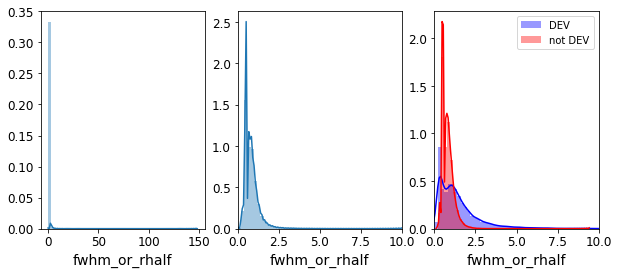

In [665]:
fig,ax= plt.subplots(1,3,figsize=(10,4))
sns.distplot(eboss['fwhm_or_rhalf'],ax=ax[0])
isSmall= (eboss['fwhm_or_rhalf'] < 10).values
sns.distplot(eboss.loc[isSmall,'fwhm_or_rhalf'],ax=ax[1])
ax[1].set_xlim(0,10)

sns.distplot(eboss.loc[(isSmall) & (isDEV),'fwhm_or_rhalf'],color='b',ax=ax[2],
             label='DEV')
sns.distplot(eboss.loc[(isSmall) & (~isDEV),'fwhm_or_rhalf'],color='r',ax=ax[2],
             label='not DEV')
ax[2].set_xlim(0,10)
ax[2].legend()



fraction NOT dev:  0.9149909634140384
fraction dev:  0.08500903658596154


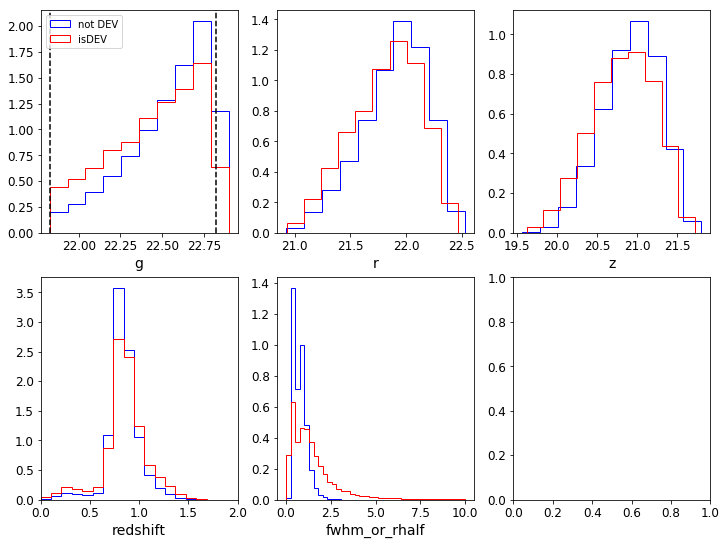

In [666]:
attrs= ['g','r','z','redshift','fwhm_or_rhalf']
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        bins=None
        if attrs[i] == 'redshift':
            bins=np.linspace(0,2,20)
        if attrs[i] == 'fwhm_or_rhalf':
            bins=np.linspace(0,10,40)            
        _=ax[row,col].hist(eboss.loc[(~isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins,label='not DEV')
        _=ax[row,col].hist(eboss.loc[(isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins,label='isDEV')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')
ax[1,0].set_xlim(0,2)

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')

print('fraction NOT dev: ',eboss[~isDEV].shape[0]/eboss.shape[0])
print('fraction dev: ',eboss[isDEV].shape[0]/eboss.shape[0])

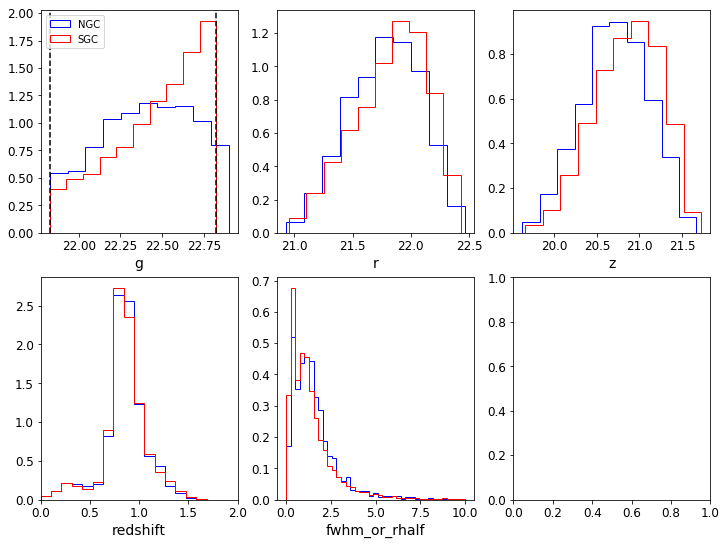

In [667]:
isNGC= eboss['field'] == 'ngc'

attrs= ['g','r','z','redshift','fwhm_or_rhalf']
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        bins=None
        if attrs[i] == 'redshift':
            bins=np.linspace(0,2,20)
        if attrs[i] == 'fwhm_or_rhalf':
            bins=np.linspace(0,10,40)            
        _=ax[row,col].hist(eboss.loc[(isNGC) & (isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins,label='NGC')
        _=ax[row,col].hist(eboss.loc[(~isNGC) & (isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins,label='SGC')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')
ax[1,0].set_xlim(0,2)

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')


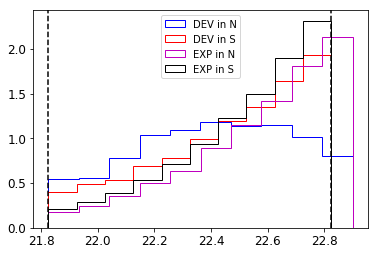

In [668]:
fig,ax= plt.subplots()           
bins=None
_=ax.hist(eboss.loc[(isNGC) & (isDEV) & (isSmall),'g'],histtype='step',normed=True,
                  color='b',bins=bins,label='DEV in N')
_=ax.hist(eboss.loc[(~isNGC) & (isDEV) & (isSmall),'g'],histtype='step',normed=True,
                  color='r',bins=bins,label='DEV in S')
_=ax.hist(eboss.loc[(isNGC) & (~isDEV) & (isSmall),'g'],histtype='step',normed=True,
                  color='m',bins=bins,label='EXP in N')
_=ax.hist(eboss.loc[(~isNGC) & (~isDEV) & (isSmall),'g'],histtype='step',normed=True,
                  color='k',bins=bins,label='EXP in S')
ax.legend() #loc='upper left')

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax.axvline(oii_emitters[0],c='k',ls='--')
ax.axvline(oii_emitters[1],c='k',ls='--')

Frac in NGC 0.3051520987009596
Frac in SGC 0.6948479012990404


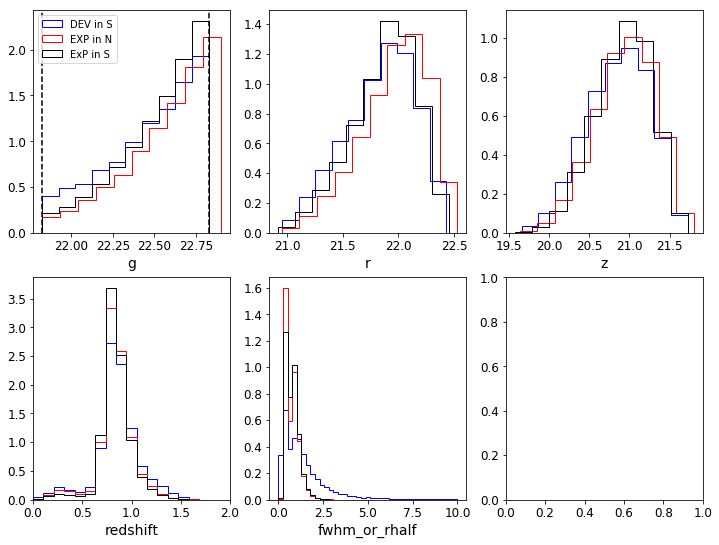

In [669]:
attrs= ['g','r','z','redshift','fwhm_or_rhalf']
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        bins=None
        if attrs[i] == 'redshift':
            bins=np.linspace(0,2,20)
        if attrs[i] == 'fwhm_or_rhalf':
            bins=np.linspace(0,10,40)            
        _=ax[row,col].hist(eboss.loc[(~isNGC) & (isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins,label='DEV in S')
        _=ax[row,col].hist(eboss.loc[(isNGC) & (~isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins,label='EXP in N')
        _=ax[row,col].hist(eboss.loc[(~isNGC) & (~isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='k',bins=bins,label='ExP in S')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')
ax[1,0].set_xlim(0,2)

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')

print('Frac in NGC',eboss[(isNGC) & (isSmall)].shape[0]/eboss[(isSmall)].shape[0])
print('Frac in SGC',eboss[(~isNGC) & (isSmall)].shape[0]/eboss[(isSmall)].shape[0])


### Need sample to extend outside eBOSS TS box
* Mag Errors won't do it ecause median g,r mag err is 0.05. Some outliers in z dmag, but no matter 0.05 in two bands isn't large enough...
* DR3-DEEP2 matched smaple in the larger of the two eBOSS boxes, but kinda need the redshift versus g,r,z,rhalf plots to look similar to the eBOSS spectra/tractor data

In [670]:
eboss.columns

Index(['field', 'g_mw_transmission', 'gflux', 'gfluxivar', 'gpsfsize',
       'r_mw_transmission', 'redshift', 'rflux', 'rfluxivar', 'rpsfsize',
       'sector_tsr', 'shapedev_r', 'shapeexp_r', 'type', 'z_mw_transmission',
       'zflux', 'zfluxivar', 'zpsfsize', 'g', 'r', 'z', 'g-r', 'r-z',
       'fwhm_or_rhalf'],
      dtype='object')

In [671]:
def ivar_ext_corr(flux_ivar, mw_trans):
    return flux_ivar * np.power(mw_trans,2)
    

def fluxErrorsToMagErrors(flux, flux_invvar):
    """From Dustin Lang's tractor.brightness module
    NanoMaggies().fluxErrorsToMagErrors
    """
    flux = np.atleast_1d(flux)
    flux_invvar = np.atleast_1d(flux_invvar)
    dflux = np.zeros(len(flux))
    okiv = (flux_invvar > 0)
    dflux[okiv] = (1./np.sqrt(flux_invvar[okiv]))
    okflux = (flux > 0)
    mag = np.zeros(len(flux))
    mag[okflux] = (flux2mag(flux[okflux]))
    dmag = np.zeros(len(flux))
    ok = (okiv * okflux)
    dmag[ok] = (np.abs((-2.5 / np.log(10.)) * dflux[ok] / flux[ok]))
    mag[np.logical_not(okflux)] = np.nan
    dmag[np.logical_not(ok)] = np.nan
    return mag.astype(np.float32), dmag.astype(np.float32)


exp_df= eboss.loc[(~isNGC) & (~isDEV) & (isSmall)]
a={}
for b in 'grz':
    #print(exp_df[b+'_mw_transmission'].values)
    flux_EC= exp_df[b+'flux']/exp_df[b+'_mw_transmission']
    ivar_EC= ivar_ext_corr(exp_df[b+'fluxivar'], 
                           exp_df[b+'_mw_transmission'])
    a[b],a[b+'_err']= fluxErrorsToMagErrors(flux_EC,ivar_EC)
    print('max diff',np.max(a[b] - exp_df[b]))

max diff 0.0
max diff 0.0
max diff 0.0


In [ ]:
exp_df['zfluxivar'] > 0.1

In [508]:
exp_df.loc[:,['gflux','gfluxivar','rflux','rfluxivar','zflux','zfluxivar',]].describe()

,gflux,gfluxivar,rflux,rfluxivar,zflux,zfluxivar
count,77707.000000,77707.000000,77707.000000,77707.000000,77707.000000,77707.000000
mean,0.888922,881.916504,1.707809,548.811218,4.328659,52.991436
std,0.224979,612.729980,0.497227,593.549988,1.494015,37.039284
min,0.423581,15.386562,0.813217,4.425666,1.855282,0.000009
25%,0.722753,531.541199,1.348789,249.192551,3.235148,28.715761
50%,0.823451,766.096497,1.585970,381.044220,3.992064,44.390278
75%,0.997608,1069.143066,1.948330,586.753754,5.091161,66.973400
max,1.758362,11717.317383,4.004512,7636.661621,14.356393,569.374512


In [504]:
pd.DataFrame(a).describe()

,g,g_err,r,r_err,z,z_err
count,77707.000000,77707.000000,77707.000000,77707.000000,77707.000000,77707.000000
mean,22.517084,0.048797,21.864561,0.036079,20.913521,0.044286
std,0.241931,0.017435,0.288296,0.015156,0.347103,0.199887
min,21.825092,0.008628,20.921309,0.004216,19.572298,0.005758
25%,22.367023,0.037267,21.682262,0.026140,20.679452,0.031045
50%,22.574741,0.046364,21.904720,0.034198,20.943573,0.040345
75%,22.715694,0.056969,22.078629,0.043640,21.171512,0.052133
max,22.824989,0.320735,22.450010,0.385943,21.730873,55.529587


In [507]:
len(a['g'][a['z_err'] > 50])

1

(0.0, 1.8)

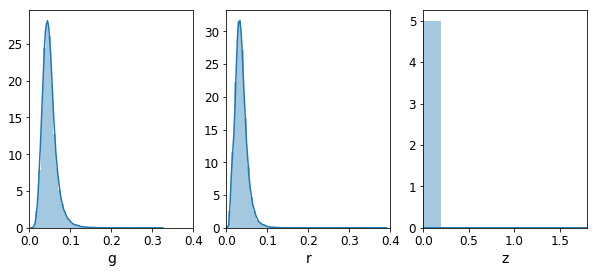

In [672]:
fig,ax= plt.subplots(1,3,figsize=(10,4))
for i,b in zip(range(3),'grz'):
    bins=None
    if b == 'z':
        bins= np.arange(0,2,0.2)
    sns.distplot(a[b+'_err'],ax=ax[i],bins=bins)
    ax[i].set_xlabel(b)
for i in range(2): 
    ax[i].set_xlim(0,0.4)
ax[2].set_xlim(bins[0],bins[-1])
#plt.xlim(-0.5,0.5)

### Use S only because deeper is more realistic

DEV in S: Number=7448, Frac=0.087
EXP in S: Number=77707, Frac=0.913


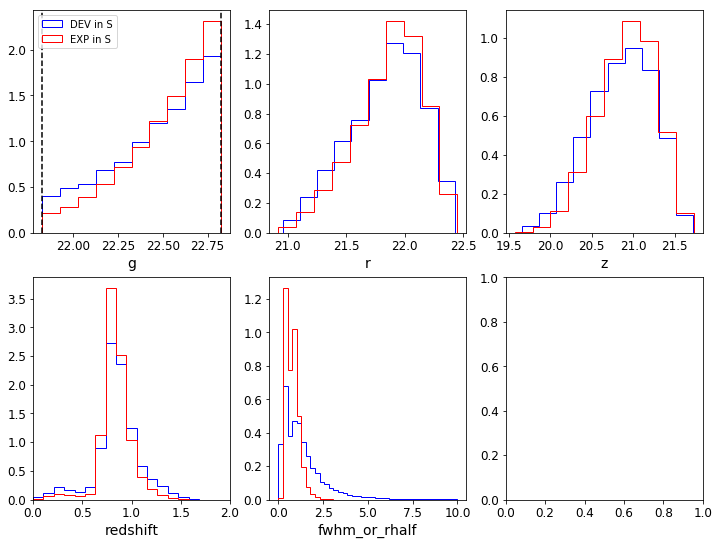

In [673]:
attrs= ['g','r','z','redshift','fwhm_or_rhalf']
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        bins=None
        if attrs[i] == 'redshift':
            bins=np.linspace(0,2,20)
        if attrs[i] == 'fwhm_or_rhalf':
            bins=np.linspace(0,10,40)            
        _=ax[row,col].hist(eboss.loc[(~isNGC) & (isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins,label='DEV in S')
        _=ax[row,col].hist(eboss.loc[(~isNGC) & (~isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins,label='EXP in S')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')
ax[1,0].set_xlim(0,2)

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')

num_in_s=dict(isDEV=eboss[(~isNGC) & (isDEV) & (isSmall)].shape[0],
              notDEV=eboss[(~isNGC) & (~isDEV) & (isSmall)].shape[0],
              total=eboss[(isSmall) & (~isNGC)].shape[0])
print('DEV in S: Number=%d, Frac=%.3f' % (num_in_s['isDEV'],num_in_s['isDEV']/num_in_s['total']))
print('EXP in S: Number=%d, Frac=%.3f' % (num_in_s['notDEV'],num_in_s['notDEV']/num_in_s['total']))

### GM for EXP

15 components


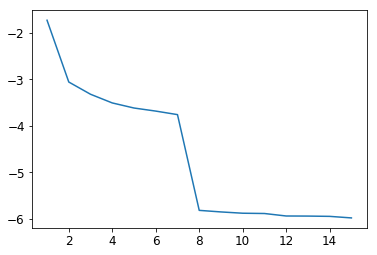

In [674]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
eboss_notdev= eboss.loc[(~isNGC) & (~isDEV) & (isSmall), fit_cols]
eboss_dev= eboss.loc[(~isNGC) & (isDEV) & (isSmall), fit_cols]
X= eboss_notdev.values

gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

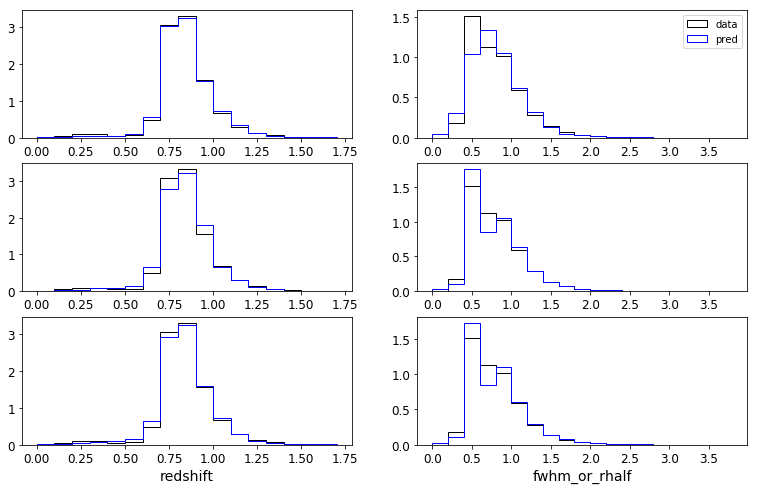

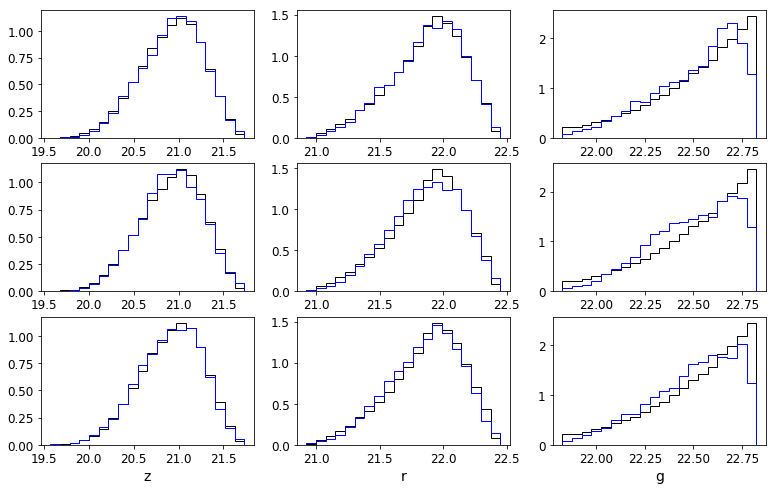

In [474]:
fig,ax= plt.subplots(3,2,figsize=(13,8))

zbins=np.arange(0.,1.8,0.1)
fwhm_bins=np.arange(0,4,0.2)
for row,n in enumerate([6,9,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(eboss_notdev['redshift'],bins=zbins,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=zbins,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,1].hist(eboss_notdev['fwhm_or_rhalf'],bins=fwhm_bins,histtype='step',color='k',normed=True,
                             label='data')
    _=ax[row,1].hist(Xpred[:,0],bins=fwhm_bins,histtype='step',color='b',normed=True,
                     label='pred')
    #ax[2].set_xlabel('fwhm_or_rhalf')
    
ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')
ax[0,1].legend()

### g,r,z
#fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
fig,ax= plt.subplots(3,3,figsize=(13,8))

for row,n in enumerate([6,9,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    # each band: z,r,g
    _,bins,_= ax[row,0].hist(eboss_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-2],bins=bins,histtype='step',color='b',normed=True)
    ax[row,0].set_xlabel('z')

    _,bins,_= ax[row,1].hist(eboss_notdev['r-z'] + eboss_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,-3] + Xpred[:,-2],bins=bins,histtype='step',color='b',normed=True)
    ax[row,1].set_xlabel('r')
    
    _,bins,_= ax[row,2].hist(eboss_notdev['g-r'] + eboss_notdev['r-z'] + eboss_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,2].hist(Xpred[:,-4] + Xpred[:,-3] + Xpred[:,-2],bins=bins,histtype='step',color='b',normed=True)
    ax[row,2].set_xlabel('g')
    
for i,b in zip(range(3),'zrg'):
    ax[-1,i].set_xlabel(b)


## Overlplot eBOSS box with 0.5 mag padding

In [592]:

def ebossInSGC(rz,gr):
    return ((-0.068*rz + 0.457 < gr) &
            (gr < 0.112*rz + 0.773) &
            (0.218*gr + 0.571 < rz) & 
            (rz < -0.555*gr + 1.901))

def ebossInNGC(rz,gr):
    return ((-0.068*rz + 0.457 < gr) &
            (gr < 0.112*rz + 0.773) &
            (0.637*gr + 0.399 < rz) & 
            (rz < -0.555*gr + 1.901))

class EbossBox(object):
    def get_xy_pad(self,slope,pad=0):
        """Returns dx,dy"""
        theta= np.arctan(abs(slope))
        return pad*np.sin(theta), pad*np.cos(theta)
    
    def get_yint_pad(self,slope,pad=0):
        """Returns dx,dy"""
        theta= np.arctan(slope)
        return pad / np.cos(theta)

    def three_lines(self,rz,pad=0):
        slopes= np.array([-0.068,0.112, 1/(-0.555)])
        yints=  np.array([0.457,0.773,-1.901/(-0.555)])
        lines= []
        for cnt,slope,yint in zip(range(len(slopes)),slopes,yints):
            dy= 0
            #dx,dy= self.get_xy_pad(slope,pad)
            dy= self.get_yint_pad(slope,pad)
            if cnt == 0:
                dy *= -1
            #lines.append(slope*(rz-dx) + yint + dy)
            lines.append(slope*rz + yint + dy)
        return tuple(lines)
    
    def sgc_line(self,rz,pad=0):
        slope,yint= 1/0.218, -0.571/0.218
        dy=0.
        #dx,dy= self.get_xy_pad(slope,pad)
        dy= self.get_yint_pad(slope,pad)
        return slope*rz + yint + dy

    def ngc_line(self,rz,pad=0):
        slope,yint= 1/0.637, -0.399/0.637
        #dx,dy= self.get_xy_pad(slope,pad)
        dy= self.get_yint_pad(slope,pad)
        return slope*rz + yint + dy

    def SGC(self,rz, pad):
        """
        Args:
            rz: r-z
            pad: magnitudes of padding to expand TS box
        """
        d['y1'],d['y2'],d['y3']= self.three_lines(rz,pad) 
        d['y4']= self.sgc_line(rz,pad)
        return d
    
    def NGC(self,rz, pad):
        """
        Args:
            rz: r-z
            pad: magnitudes of padding to expand TS box
        """
        d['y1'],d['y2'],d['y3']= self.three_lines(rz,pad) 
        d['y4']= self.ngc_line(rz,pad)
        return d

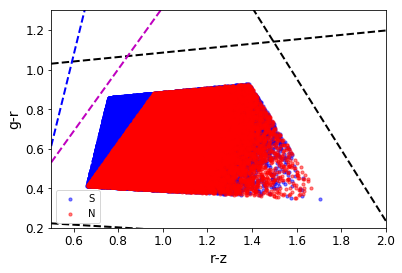

In [582]:
plt.scatter(df.loc[(~isNGC) & (~isDEV) & (isSmall),'r-z'],
              df.loc[(~isNGC) & (~isDEV) & (isSmall),'g-r'],
              c='b',s=10,alpha=0.5,label='S')
plt.scatter(df.loc[(isNGC) & (~isDEV) & (isSmall),'r-z'],
              df.loc[(isNGC) & (~isDEV) & (isSmall),'g-r'],
              c='r',s=10,alpha=0.5,label='N')

rz= np.linspace(0.5,2,num=20)
ngc_d= EbossBox().NGC(rz,pad=0.2)
plt.plot(rz,ngc_d['y1'],'k--',lw=2)
plt.plot(rz,ngc_d['y2'],'k--',lw=2)
plt.plot(rz,ngc_d['y3'],'k--',lw=2)
plt.plot(rz,ngc_d['y4'],'m--',lw=2)

sgc_d= EbossBox().SGC(rz,pad=0.2)
plt.plot(rz,sgc_d['y4'],'b--',lw=2)


plt.legend()
plt.xlim(0.5,2)
plt.ylim(0.2,1.3)
plt.xlabel('r-z')
plt.ylabel('g-r')

### DR3-Deep2

In [654]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                               
print(dr3_fns,dp2_fns)
###
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)
print(len(dr3),len(dp2))
#######
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
notCOMP= dr3.type != 'COMP'
###
fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= dr3.type == 'PSF'
isEXP= dr3.type == 'EXP'
isSIMP= dr3.type == 'SIMP'
isDEV= dr3.type == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r
dr3.set('fwhm_or_rhalf',fwhm_or_rhalf)
###
reshift_lims= [0,1.8] # eBOSS 
###
keep= ((grz_gt0) & 
       (notCOMP) & 
       (fwhm_or_rhalf < 5) & 
       (dp2.zhelio > reshift_lims[0]) & 
       (dp2.zhelio < reshift_lims[1]))
dr3.cut(keep)
dp2.cut(keep)
###
d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr3.fwhm_or_rhalf
d['type']= dr3.get('type')
dr3_deep2= pd.DataFrame(d)
###
print(df['type'].value_counts()/df.shape[0])
isDEV= dr3_deep2['type'] == 'DEV'
dr3_deep2['r-z']= dr3_deep2['r'] - dr3_deep2['z']
dr3_deep2['g-r']= dr3_deep2['g'] - dr3_deep2['r']


['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-fi

### DR3-DP2 in eBOSS Box

25425
112100
927
10423


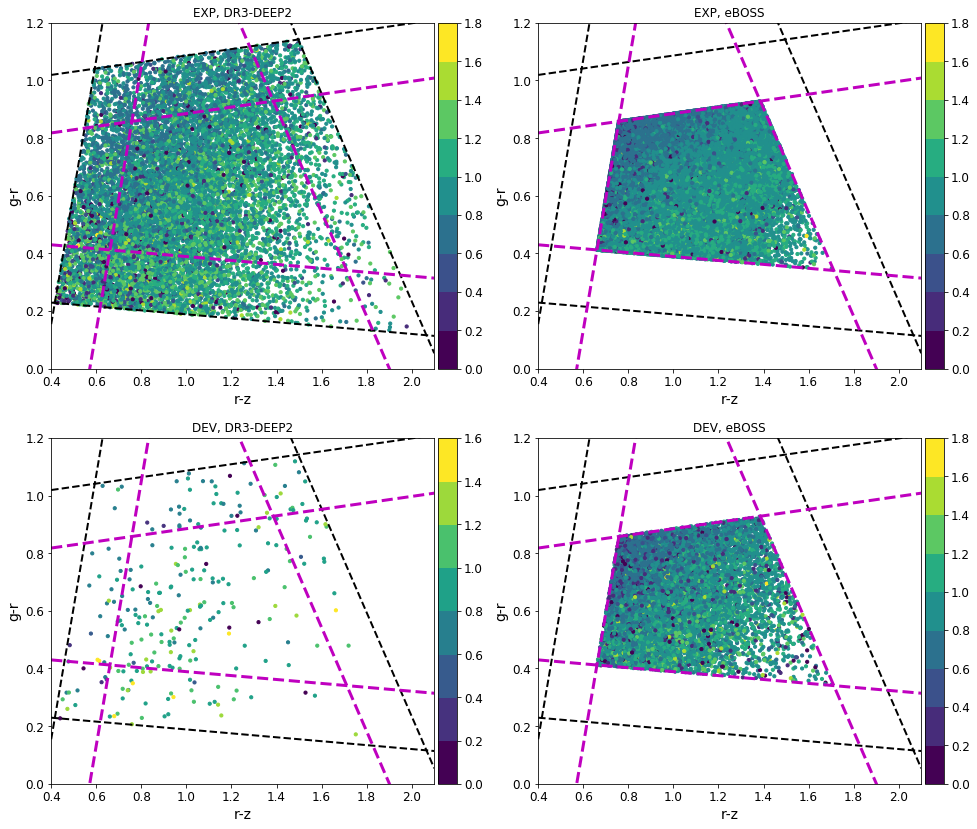

In [683]:
def eboss_scatterplot(rz,gr,redshift,
                      fig,ax,pad=0.):
    """Given cleaned gr,gr, and redshifts, cuts to padded SGC region
    and plots scatter plot colored by redshift"""
    #inSGC= ebossInSGC(df['r-z'],df['g-r'])
    sgc_d= EbossBox().SGC(rz,pad=mag_pad)
    inSGC= ((gr > sgc_d['y1']) & 
            (gr < sgc_d['y2']) &
            (gr < sgc_d['y3']) &
            (gr < sgc_d['y4']))
    
    import matplotlib.colors as colors
    vmin= redshift[inSGC].min()
    vmax= redshift[inSGC].max()
    bounds= np.arange(vmin,vmax+0.2,0.2)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    scat= ax.scatter(rz[inSGC], gr[inSGC],
                     c=redshift[inSGC],s=10,alpha=1,
                     vmin=vmin,vmax=vmax,norm=norm)
    rz_pts= np.linspace(0.4,2.1,num=20)
    sgc_d= EbossBox().SGC(rz_pts,pad=mag_pad)
    for key in ['y1','y2','y3','y4']:
        ax.plot(rz_pts,sgc_d[key],'k--',lw=2)
    # eBOSS Box
    sgc_d= EbossBox().SGC(rz_pts,pad=0.)
    for key in ['y1','y2','y3','y4']:
        ax.plot(rz_pts,sgc_d[key],'m--',lw=3)

    ax.set_xlabel('r-z')
    ax.set_ylabel('g-r')
    ax.set_xlim(rz_pts[0],rz_pts[-1])
    ax.set_ylim(0,1.2)
    print(len(rz))

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(scat, cax=cax, orientation='vertical')

# eBOSS data
reshift_lims= [0,1.8] # eBOSS 
eboss_zcut= eboss[((eboss['redshift'] > reshift_lims[0]) & 
                   (eboss['redshift'] < reshift_lims[1]))]
    
fig,ax=plt.subplots(2,2,figsize=(16,14))
pad=0.2
# EXP
isDEV= dict(dr3= dr3_deep2['type'].str.strip() == 'DEV',
            eboss= eboss_zcut['type'].str.strip() == 'DEV')
eboss_scatterplot(dr3_deep2.loc[~isDEV['dr3'],'r-z'],dr3_deep2.loc[~isDEV['dr3'],'g-r'],
                  dr3_deep2.loc[~isDEV['dr3'],'redshift'],
                  fig,ax[0,0],pad=pad)
eboss_scatterplot(eboss_zcut.loc[~isDEV['eboss'],'r-z'],eboss_zcut.loc[~isDEV['eboss'],'g-r'],
                  eboss_zcut.loc[~isDEV['eboss'],'redshift'],
                  fig,ax[0,1],pad=pad)
ax[0,0].set_title('EXP, DR3-DEEP2')
ax[0,1].set_title('EXP, eBOSS')

# DEV
eboss_scatterplot(dr3_deep2.loc[isDEV['dr3'],'r-z'],dr3_deep2.loc[isDEV['dr3'],'g-r'],
                  dr3_deep2.loc[isDEV['dr3'],'redshift'],
                  fig,ax[1,0],pad=pad)
eboss_scatterplot(eboss_zcut.loc[isDEV['eboss'],'r-z'],eboss_zcut.loc[isDEV['eboss'],'g-r'],
                  eboss_zcut.loc[isDEV['eboss'],'redshift'],
                  fig,ax[1,1],pad=pad)
ax[1,0].set_title('DEV, DR3-DEEP2')
ax[1,1].set_title('DEV, eBOSS')



### Not enough DEV in DEEP2 match to fill in outside eBOSS box, so just use EXP (90% of galaxy types, so its a start)

In [689]:
for attr in attrs:
    print(attr,attr in dr3_deep2.columns,attr in eboss.columns)

g True True
r True True
z True True
redshift True True
fwhm_or_rhalf True True


EXP, DR3-DP2: Number=25425
EXP, eBOSS: Number=112100


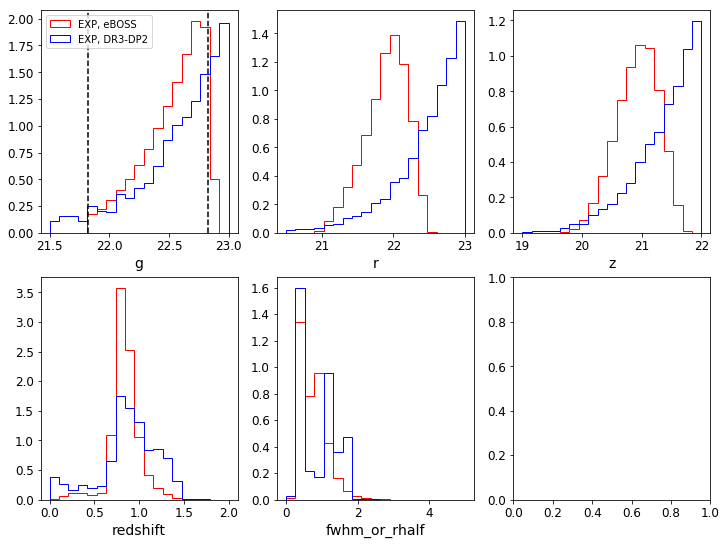

In [694]:
attrs= ['g','r','z','redshift','fwhm_or_rhalf']
bins=dict(g=np.linspace(21.5,23,20),
          r=np.linspace(20.5,23,20),
          z=np.linspace(19,22,20),
          redshift=np.linspace(0,2,20),
          fwhm_or_rhalf=np.linspace(0,5,20))
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue         
        _=ax[row,col].hist(eboss_zcut.loc[~isDEV['eboss'],attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins[attrs[i]],label='EXP, eBOSS')
        _=ax[row,col].hist(dr3_deep2.loc[~isDEV['dr3'],attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins[attrs[i]],label='EXP, DR3-DP2')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')

#gband
oii_emitters= [21.825, 22.825]
#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')

print('EXP, DR3-DP2: Number=%d' % dr3_deep2[~isDEV['dr3']].shape[0])
print('EXP, eBOSS: Number=%d' % eboss_zcut[~isDEV['eboss']].shape[0])
      

EXP, DR3-DP2: Number=757
EXP, eBOSS: Number=112100


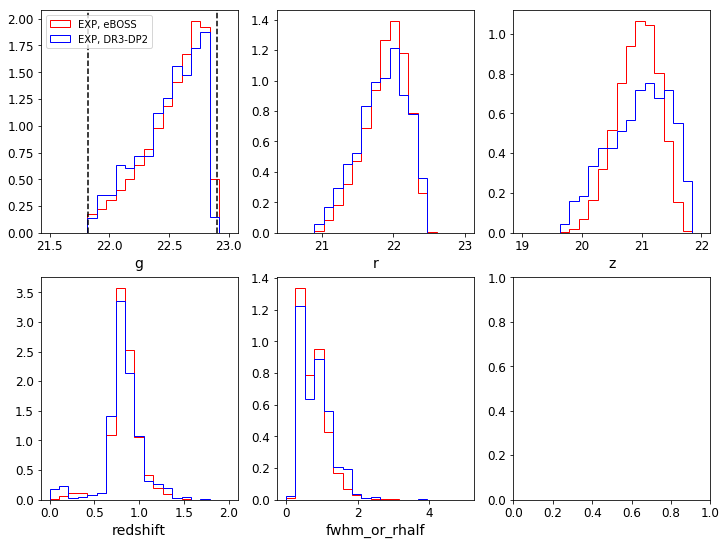

In [703]:
# If cut dr3-dp2 to eboss gmag, does it make the same as eBOSS

#oii_emitters= [21.825, 22.825]
lim_pad=0.05
g_lim= [eboss_zcut.loc[~isDEV['eboss'],'g'].min() +lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'g'].max() -lim_pad]
r_lim= [eboss_zcut.loc[~isDEV['eboss'],'r'].min() + lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'r'].max() - lim_pad]
z_lim= [eboss_zcut.loc[~isDEV['eboss'],'z'].min() + lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'z'].max() - lim_pad]


dr3_deep2_gcut= dr3_deep2[((~isDEV['dr3']) & 
                           (dr3_deep2['g'] >= g_lim[0]) &
                           (dr3_deep2['g'] <= g_lim[1]) &
                           (dr3_deep2['r'] >= r_lim[0]) &
                           (dr3_deep2['r'] <= r_lim[1]) & 
                           (dr3_deep2['z'] >= z_lim[0]) &
                           (dr3_deep2['z'] <= z_lim[1]))]

attrs= ['g','r','z','redshift','fwhm_or_rhalf']
bins=dict(g=np.linspace(21.5,23,20),
          r=np.linspace(20.5,23,20),
          z=np.linspace(19,22,20),
          redshift=np.linspace(0,2,20),
          fwhm_or_rhalf=np.linspace(0,5,20))
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue         
        _=ax[row,col].hist(eboss_zcut.loc[~isDEV['eboss'],attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins[attrs[i]],label='EXP, eBOSS')
        _=ax[row,col].hist(dr3_deep2_gcut[attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins[attrs[i]],label='EXP, DR3-DP2')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')

#gband

#ax[0,0].set_xlim(oii_emitters)
ax[0,0].axvline(oii_emitters[0],c='k',ls='--')
ax[0,0].axvline(oii_emitters[1],c='k',ls='--')

print('EXP, DR3-DP2: Number=%d' % dr3_deep2_gcut.shape[0])
print('EXP, eBOSS: Number=%d' % eboss_zcut[~isDEV['eboss']].shape[0])

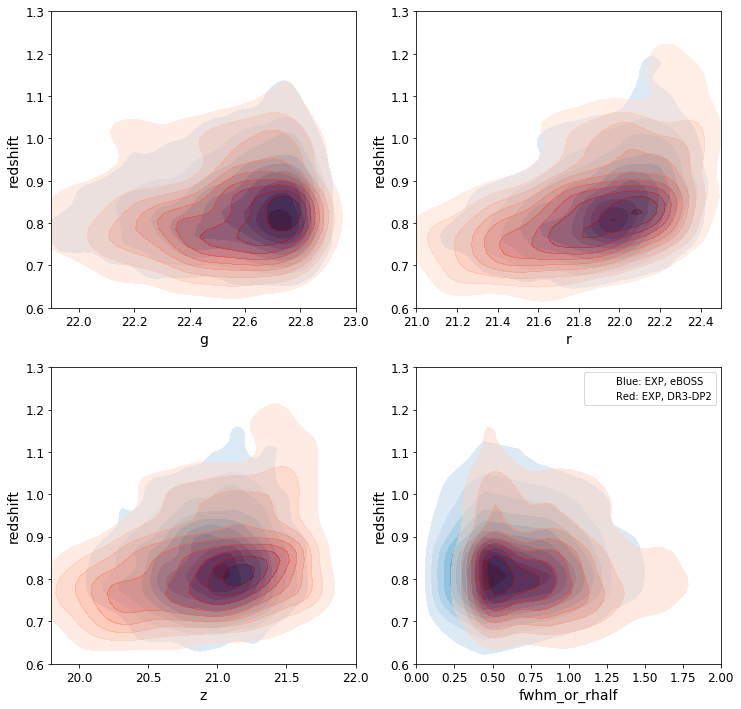

In [730]:
## Reduce size of eboss_zcut so can plot
iboot=np.random.randint(0,eboss_zcut[~isDEV['eboss']].shape[0],size=5000)
kwargs= dict(shade=True, shade_lowest=False)
##


lim_pad=0.05
g_lim= [eboss_zcut.loc[~isDEV['eboss'],'g'].min() +lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'g'].max() -lim_pad]
r_lim= [eboss_zcut.loc[~isDEV['eboss'],'r'].min() + lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'r'].max() - lim_pad]
z_lim= [eboss_zcut.loc[~isDEV['eboss'],'z'].min() + lim_pad,
        eboss_zcut.loc[~isDEV['eboss'],'z'].max() - lim_pad]


dr3_deep2_gcut= dr3_deep2[((~isDEV['dr3']) & 
                           (dr3_deep2['g'] >= g_lim[0]) &
                           (dr3_deep2['g'] <= g_lim[1]) &
                           (dr3_deep2['r'] >= r_lim[0]) &
                           (dr3_deep2['r'] <= r_lim[1]) & 
                           (dr3_deep2['z'] >= z_lim[0]) &
                           (dr3_deep2['z'] <= z_lim[1]))]

attrs= ['g','r','z','fwhm_or_rhalf']
xylims=dict(g=(21.9,23),
          r=(21,22.5),
          z=(19.8,22),
          redshift=(0.6,1.3),
          fwhm_or_rhalf=(0,2))
fig,ax= plt.subplots(2,2,figsize=(12,12))
i=-1
for row in range(2):
    for col in range(2):
        i+=1
        if i >= len(attrs):
            continue         
#         ax[row,col].scatter(eboss_zcut.loc[~isDEV['eboss'],attrs[i]],
#                             eboss_zcut.loc[~isDEV['eboss'],'redshift'],
#                             c='b',s=10,alpha=0.5,label='EXP, eBOSS')
#         ax[row,col].scatter(dr3_deep2_gcut[attrs[i]],
#                             dr3_deep2_gcut['redshift'],
#                             c='r',s=10,alpha=0.5,label='EXP, DR3-DP2')
        sns.kdeplot(eboss_zcut.loc[~isDEV['eboss'],attrs[i]].iloc[iboot],
                    eboss_zcut.loc[~isDEV['eboss'],'redshift'].iloc[iboot],
                    ax= ax[row,col], cmap='Blues', label='EXP, eBOSS',alpha=1,**kwargs)
        sns.kdeplot(dr3_deep2_gcut[attrs[i]],
                    dr3_deep2_gcut['redshift'],
                    ax= ax[row,col], cmap="Reds", label='EXP, DR3-DP2',alpha=0.5,**kwargs)
        ax[row,col].set_xlim(xylims[attrs[i]])
        ax[row,col].set_ylim(xylims['redshift'])
        ax[row,col].set_xlabel(attrs[i])
ax[1,1].legend(['Blue: EXP, eBOSS',
                'Red: EXP, DR3-DP2'],loc='upper right')

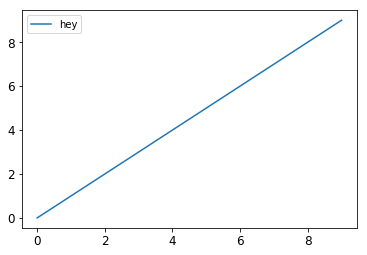

In [729]:
fig,ax=plt.subplots()
ax.plot(range(10))
ax.legend(['hey','you'])

### GM for DEV

14 components


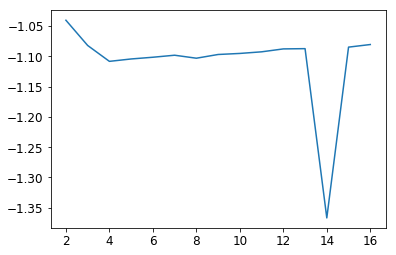

In [435]:
df_dev= df.loc[(~isNGC) & (isDEV) & (isSmall), fit_cols]

gmms,i_min, n_comp, BICs= my_mixture(np.array(X).reshape(-1,1),
                                     n_comp=np.arange(2,17))
plt.plot(n_comp,BICs)

fig,ax= plt.subplots(4,1,figsize=(7,12))

for col,n in enumerate([3,6,8,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _=ax[col].hist(X,bins=zbins,histtype='step',color='b',normed=True)
    _=ax[col].hist(Xpred,bins=zbins,histtype='step',color='r',normed=True)
    
ax[-1].set_xlabel('redshift')

# n(z) for ELG eBOSS

#### Right is the n(z) Anand Raichoor provided me, Left is my reproduction of it

<img src="eboss_nz.png" width="400">

zbins= [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8]
number zs from EXP:  77707
number zs from DEV:  7448


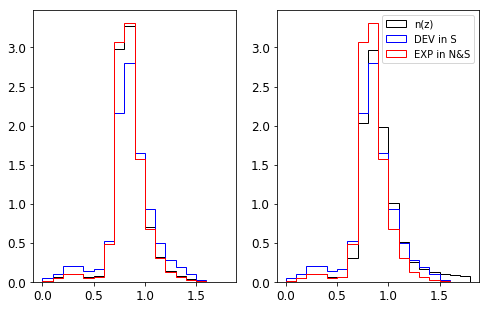

In [321]:
zbins= np.arange(0,1.8+0.1,0.1)
print('zbins=',zbins)
print('number zs from EXP: ',df[(~isNGC) & (~isDEV) & (isSmall)].shape[0])
print('number zs from DEV: ',df[(~isNGC) & (isDEV)  & (isSmall)].shape[0])

fig,ax=plt.subplots(1,2,figsize=(8,5))
for i,wt,name in zip(range(2),[np.ones(df.shape[0]), df['sector_tsr'].values],
                              ['No wt', 'tsr']):
    nz= (df['redshift'] / wt)[(~isNGC) & (isSmall)]
    _=ax[i].hist(nz,histtype='step',normed=True,
              color='k',bins=zbins,label='n(z)')     
    _=ax[i].hist(df.loc[(~isNGC) & (isDEV) & (isSmall),'redshift'],histtype='step',normed=True,
                color='b',bins=zbins,label='DEV in S')
    _=ax[i].hist(df.loc[(~isNGC) & (~isDEV) & (isSmall),'redshift'],histtype='step',normed=True,
                       color='r',bins=zbins,label='EXP in N&S')
ax[1].legend()

In [333]:
df_z= df[(~isNGC) & (isSmall)]

zbins= np.arange(-0.05,1.8+0.1,0.1)
print('zbins=',zbins)
df_z['bins']= pd.cut(df_z['redshift'],bins=zbins)
df_z['wt']= 1/df_z['sector_tsr']
nz= df_z.loc[:,['wt','bins']].groupby('bins').agg(np.sum)
nz.head()

zbins= [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85]


/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,wt
bins,
"(-0.05, 0.05]",67.798508
"(0.05, 0.15]",260.603088
"(0.15, 0.25]",770.552368
"(0.25, 0.35]",1135.730469
"(0.35, 0.45]",634.638245


redshift bins= [-0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.05
  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85]
bin centers= Float64Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
              1.3, 1.4, 1.5, 1.6, 1.7, 1.8],
             dtype='float64')
redshift bins2= [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4
  1.5  1.6  1.7  1.8]
bin centers2= Float64Index([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
              1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75],
             dtype='float64')


/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


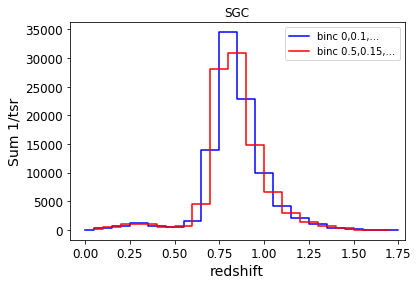

In [345]:
zbins2= np.arange(0.,1.8+0.1,0.1)
df_z['bins2']= pd.cut(df_z['redshift'],bins=zbins2)
nz2= df_z.loc[:,['wt','bins2']].groupby('bins2').agg(np.sum)

print('redshift bins=',zbins)
print('bin centers=', nz.index.categories.mid)
print('redshift bins2=',zbins2)
print('bin centers2=', nz2.index.categories.mid)
plt.step(nz.index.categories.mid,nz['wt'],where='mid',c='b',label='binc 0,0.1,...')
plt.step(nz2.index.categories.mid,nz2['wt'],where='mid',c='r',label='binc 0.5,0.15,...')
plt.xlabel('redshift')
plt.ylabel('Sum 1/tsr')
plt.title('SGC')
plt.legend()

redshift bins= [ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18  0.2   0.22
  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42  0.44  0.46
  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66  0.68  0.7
  0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9   0.92  0.94
  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1   1.12  1.14  1.16  1.18
  1.2   1.22  1.24  1.26  1.28  1.3   1.32  1.34  1.36  1.38  1.4   1.42
  1.44  1.46  1.48  1.5   1.52  1.54  1.56  1.58  1.6   1.62  1.64  1.66
  1.68  1.7   1.72  1.74  1.76  1.78  1.8 ]
bin centers= Float64Index([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
              0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
              0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
              0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
              0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01, 1.03, 1.05, 1.07, 1.09,
              1.11

/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


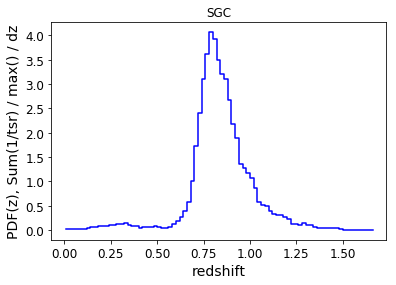

In [394]:
dz= 0.02
zbins= np.arange(0,1.8+dz,dz)
df_z['bins']= pd.cut(df_z['redshift'],bins=zbins)
nz= df_z.loc[:,['wt','bins']].groupby('bins').agg(np.sum)
nz['wt']= nz['wt']/np.sum(nz['wt'])

print('redshift bins=',zbins)
print('bin centers=', nz.index.categories.mid)
plt.step(nz.index.categories.mid,nz['wt']/dz,where='mid',c='b')
plt.xlabel('redshift')
plt.ylabel('PDF(z), Sum(1/tsr) / max() / dz')
plt.title('SGC')

print('isNORMED?', np.sum(nz['wt']/dz) * dz)

its nan 1.67 nan
its nan 1.69 nan
its nan 1.71 nan
its nan 1.73 nan
its nan 1.75 nan
its nan 1.77 nan
its nan 1.79 nan
9959 0.01


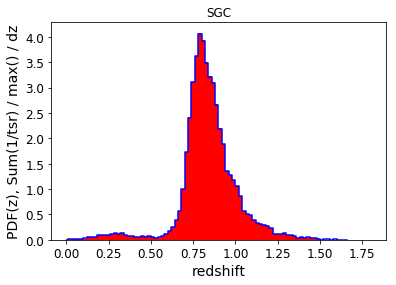

In [398]:
nz_pdf= nz['wt'].values
redshifts= nz.index.categories.mid.values
X= []
for z,num in zip(redshifts, nz_pdf * 10000):
    if not np.isfinite(num):
        print('its nan',z,num)
        continue
    X += [z] * int(num)
# for z,num in zip(redshifts, nz_pdf * 10000):
#     print(z,int(num))
print(len(X),X[0])

plt.step(nz.index.categories.mid,nz['wt']/dz,where='mid',c='b',label='exact')
_=plt.hist(X,bins=zbins, normed=True,color='r',label='approx')
plt.xlabel('redshift')
plt.ylabel('PDF(z), Sum(1/tsr) / max() / dz')
plt.title('SGC')

In [ ]:
gmms,i_min, n_comp, BICs= my_mixture(np.array(X).reshape(-1,1),
                                     n_comp=np.arange(2,17))
plt.plot(n_comp,BICs)

### Go with 10 components suff to overfit 

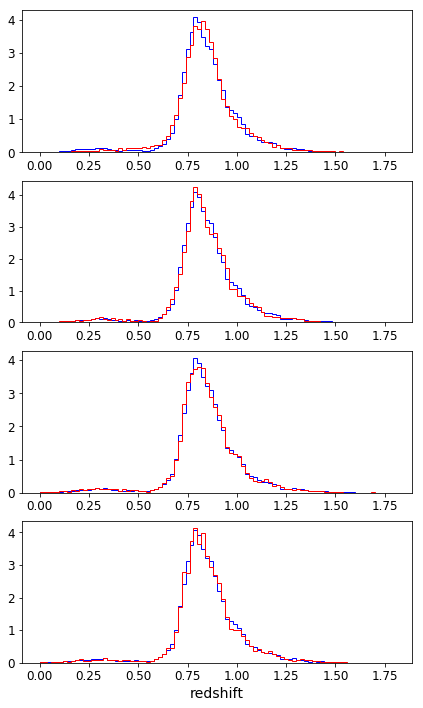

In [442]:
fig,ax= plt.subplots(4,1,figsize=(7,12))

for col,n in enumerate([3,6,8,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _=ax[col].hist(X,bins=zbins,histtype='step',color='b',normed=True)
    _=ax[col].hist(Xpred,bins=zbins,histtype='step',color='r',normed=True)
    
ax[-1].set_xlabel('redshift')

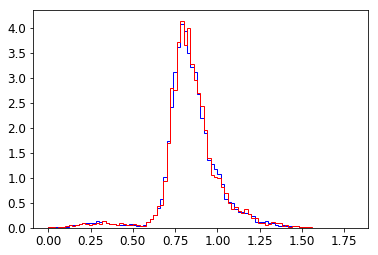

In [453]:
gmm= gmms[np.where(n_comp == 10)[0][0]]
z_pred,pdf_pred= gmm.sample(10000)
_=plt.hist(X,bins=zbins,histtype='step',color='b',normed=True)
_=plt.hist(Xpred,bins=zbins,histtype='step',color='r',normed=True)

### Save model

In [456]:
GaussianMixtureModel.save(gmm, filename='eboss_nz_elg')

Wrote eboss_nz_elg_means.txt
Wrote eboss_nz_elg_weights.txt
Wrote eboss_nz_elg_covars.txt


# eBOSS DR3 CCDS

In [206]:
ccd_coadd= fits_table(os.path.join(os.environ['HOME'],'Downloads',
                         'ebossDR3','legacysurvey-3583p000-ccds.fits'))
#dr3_ccds= fits_table(os.path.join(os.environ['HOME'],'Downloads',
#                         'ebossDR3','survey-ccds-decals.fits.gz'))
#dr3_ccds= fits_table(os.path.join(os.environ['HOME'],'Downloads',
#                         'ebossDR3','survey-ccds-extra.fits.gz'))
dr3_ccds= fits_table(os.path.join(os.environ['HOME'],'Downloads',
                         'ebossDR3','survey-ccds-nondecals.fits.gz'))

Converted object from |S37 to <U37
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S61 to <U61
Converted plver from |S4 to <U4
Converted skyver from |S16 to <U16
Converted wcsver from |S1 to <U1
Converted psfver from |S12 to <U12
Converted skyplver from |S4 to <U4
Converted wcsplver from |S4 to <U4
Converted psfplver from |S4 to <U4
Converted object from |S35 to <U35
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S61 to <U61


In [207]:
print(len(ccd_coadd.get_columns()), len(dr3_ccds.get_columns()))
same_cols= set(ccd_coadd.get_columns()).intersection(set(dr3_ccds.get_columns()))
print(len(same_cols))

70 52
52


In [208]:
print(ccd_coadd.ccdname[0],ccd_coadd.image_filename[0],ccd_coadd.date_obs[0])
print(dr3_ccds.ccdname[0],dr3_ccds.image_filename[0])


S25 decam/CPDES82/c4d_130902_061728_ooi_g_v1.fits.fz              2013-09-02
S29 decam/NonDECaLS/CP20130129/c4d_130130_004145_ooi_r_v1.fits.fz


In [209]:
i= ((pd.Series(dr3_ccds.ccdname).str.strip() == 'S25') &
    (pd.Series(dr3_ccds.image_filename).str.strip() == \
               'decam/CPDES82/c4d_130902_061728_ooi_g_v1.fits.fz'))

In [210]:
dr3_ccds[i]

<tabledata object with 1 rows and 52 columns: object=DES survey hex -12-14 tiling 4     , expnum=229686, exptime=90.0, filter=g, seeing=1.72676, date_obs=2013-09-02, mjd_obs=56537.2621324, ut=06:17:28.238325, ha=00:24:18.570 , airmass=1.16, propid=2012B-0001, zpt=25.2166, avsky=124.355, arawgain=4.6, fwhm=7.44643, crpix1=11167.8, crpix2=8436.0, crval1=358.871992422, crval2=-0.635496023898, cd1_1=-7.99839e-08, cd1_2=7.28623e-05, cd2_1=-7.28599e-05, cd2_2=-8.01916e-08, ccdnum=4, ccdname=S25, ccdzpt=25.2163, ccdzpta=25.2169, ccdzptb=25.2181, ccdphoff=0.263215, ccdphrms=0.0156626, ccdskyrms=6.17303, ccdskymag=21.6912, ccdskycounts=124.622, ccdraoff=-0.0104072, ccddecoff=-0.015203, ccdtransp=1.30667, ccdnstar=72, ccdnmatch=52, ccdnmatcha=30, ccdnmatchb=22, ccdmdncol=1.63293, temp=10.1, camera=decam, expid=00229686-S25, image_hdu=4, image_filename=decam/CPDES82/c4d_130902_061728_ooi_g_v1.fits.fz             , width=2046, height=4094, ra_bore=358.871992422, dec_bore=-0.635496023898, ra=358.40

In [212]:
for col in list(same_cols):
    print(ccd_coadd.get(col)[0],dr3_ccds[i].get(col)[0])

229686 229686
124.622 124.622
-7.99839e-08 -7.99839e-08
22 22
-0.0104072 -0.0104072
decam decam
DES survey hex -12-14 tiling 4        DES survey hex -12-14 tiling 4     
00229686-S25 00229686-S25
25.2166 25.2166
7.44643 7.44643
g g
2012B-0001 2012B-0001
-8.01916e-08 -8.01916e-08
25.2169 25.2169
-0.635496023898 -0.635496023898
2046 2046
S25 S25
358.407016199 358.407016199
-0.635496023898 -0.635496023898
52 52
1.16 1.16
72 72
90.0 90.0
4 4
358.871992422 358.871992422
1.63293 1.63293
0.0156626 0.0156626
21.6912 21.6912
11167.8 11167.8
10.1 10.1
6.17303 6.17303
00:24:18.570  00:24:18.570 
56537.2621324 56537.2621324
8436.0 8436.0
06:17:28.238325 06:17:28.238325
25.2181 25.2181
0.263215 0.263215
4 4
4.6 4.6
decam/CPDES82/c4d_130902_061728_ooi_g_v1.fits.fz              decam/CPDES82/c4d_130902_061728_ooi_g_v1.fits.fz             
30 30
4094 4094
2013-09-02 2013-09-02
-7.28599e-05 -7.28599e-05
7.28623e-05 7.28623e-05
1.72676 1.72676
124.355 124.355
1.30667 1.30667
-0.015203 -0.015203
25.2163 

## which bricks used same ccds eBOSS/DR3 and which did not (e.g. more in eBOSS)?
### Is it always more in eBOSS?

In [213]:
allccds= [fits_table(os.path.join(os.environ['HOME'],'Downloads',
                            'ebossDR3','survey-ccds-%s.fits.gz' % name))
          for name in ['decals','extra','nondecals']]
allccds= merge_tables(allccds, columns='fillzero')

Converted object from |S35 to <U35
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S61 to <U61
Converted object from |S37 to <U37
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Converted image_filename from |S61 to <U61
Converted object from |S35 to <U35
Converted filter from |S1 to <U1
Converted date_obs from |S10 to <U10
Converted ut from |S15 to <U15
Converted ha from |S13 to <U13
Converted propid from |S10 to <U10
Converted ccdname from |S3 to <U3
Converted camera from |S5 to <U5
Converted expid from |S12 to <U12
Conve

In [230]:
expids= pd.Series(.expid).str.split('-').str[0].values
ccdnames= pd.Series(dr3_ccds.ccdname).str.strip().values

7944

# Rongpu's Stellar Density model
* f(b,l) + 3 params for normalization
* first try: normalize to avg star counts in some bricks at specifc b,l
  * 12 < G_gaia < 16
  * does model predict nstars similar to number in tractor cats?
* improve on first try: give Rongpu a new G_gaia range for the stars I'm intereseted in and get the new normalizataion params from him


In [143]:
def nstars(l, b):
    """Rongpu Zhou's model
    https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=2966
    """
    c1, c2, c3 =  [0.56099869, 0.08483852,  0.428828]
    return (1/np.sin(np.abs(b)/180*np.pi)-1) * \
            (1+c1*np.cos(l/180*np.pi)+c2*np.cos(2*l/180*np.pi))+c3

    
xv, yv = np.meshgrid(np.linspace(-180,180,1000),np.linspace(-80,80,1000))
n= nstars(xv,yv)
n.shape

(1000, 1000)

1.33336159055


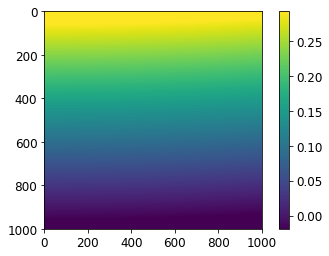

In [155]:
xv, yv = np.meshgrid(np.linspace(0,20,1000),np.linspace(30,50,1000))
n= nstars(xv,yv)
print(np.median(n))

vmin,vmax= np.percentile(n,q=5),np.percentile(n,q=95)
plt.imshow(np.log10(n),vmin=np.log10(vmin),vmax=np.log10(vmax))
plt.colorbar()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

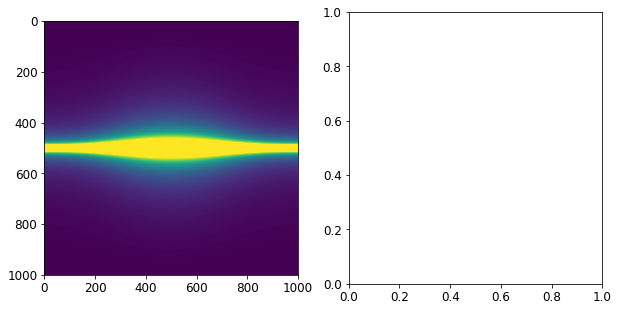

In [149]:
vmin,vmax= np.percentile(n,q=5),np.percentile(n,q=95)
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(n,vmin=vmin,vmax=vmax)
plt.colorbar(ax=ax[0])

ax[1].imshow(np.log10(n),vmin=np.log10(vmin),vmax=np.log10(vmax))
ax[1].colorbar()

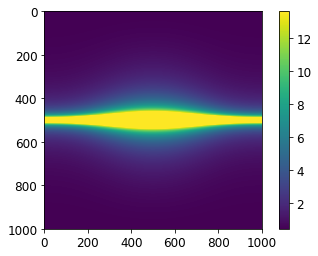

In [150]:
vmin,vmax= np.percentile(n,q=5),np.percentile(n,q=95)
plt.imshow(n,vmin=vmin,vmax=vmax)
plt.colorbar()

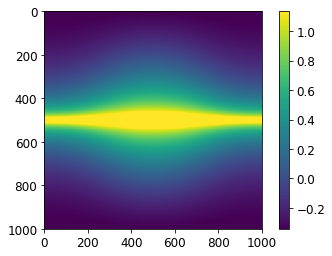

In [151]:
plt.imshow(np.log10(n),vmin=np.log10(vmin),vmax=np.log10(vmax))
plt.colorbar()

0.436909073748 1176.345523


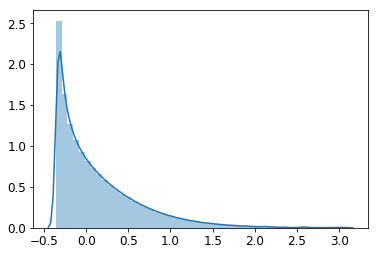

In [146]:
sns.distplot(np.log10(n.flatten()))
#plt.xlim(-1,1)
print(n.min(),n.max())

In [ ]:
#sns.distplot(np.log10(n.flatten()))

# DR5

In [583]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr5_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/decals-dr5.0-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/deep2-field*-trim.fits'))                                                               
print(dr5_fns,dp2_fns)

dr5= stack_tables(dr5_fns)
dp2= stack_tables(dp2_fns)

['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted typ

In [584]:
def get_xy_pad(slope,pad):
    """Returns dx,dy"""
    theta= np.arctan(abs(slope))
    return pad*np.sin(theta), pad*np.cos(theta)

def y1_line(rz,pad=None):
    slope,yint= 1.15,-0.15
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz+dx) + yint + dy
    else:
        return slope*rz + yint
    
def y2_line(rz,pad=None):
    slope,yint= -1.2,1.6
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz-dx) + yint + dy
    else:
        return slope*rz + yint

def get_ELG_box(rz,gr, pad=None):
    """
    Args:
        rz: r-z
        gr: g-r
        pad: magnitudes of padding to expand TS box
    """
    x1,y1= rz,y1_line(rz)
    x2,y2= rz,y2_line(rz)
    x3,y3= np.array([0.3]*len(rz)),gr
    x4,y4= np.array([1.6]*len(rz)),gr
    if pad:
        dx,dy= get_xy_pad(1.15,pad)
        x1,y1= x1-dx,y1+dy
        dx,dy= get_xy_pad(-1.2,pad)
        x2,y2= x2+dx,y2+dy
        x3 -= pad
        x4 += pad
    return dict(x1=x1, y1=y1,
                x2=x2, y2=y2,
                x3=x3, y3=y3,
                x4=x4, y4=y4)

In [585]:
grz_gt0= ((dr5.flux_g > 0) &
          (dr5.flux_r > 0) &
          (dr5.flux_z > 0) &
          (dr5.flux_ivar_g > 0) &
          (dr5.flux_ivar_r > 0) &
          (dr5.flux_ivar_z > 0))
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr5))-1 # arcsec
isPSF= np.char.strip(dr5.type) == 'PSF'
isEXP= pd.Series(np.char.strip(dr5.type)).isin(['EXP','REX'])
isSIMP= np.char.strip(dr5.type) == 'SIMP'
isDEV= np.char.strip(dr5.type) == 'DEV'
isCOMP= np.char.strip(dr5.type) == 'COMP'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([dr5[isPSF].psfsize_g,
                                        dr5[isPSF].psfsize_r,
                                        dr5[isPSF].psfsize_z]),axis=0)/2
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr5[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr5[isDEV].shapedev_r
dr5.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr5),len(dp2))
print(len(dr5[grz_gt0]), len(dr5[isDEV]), len(dr5[isCOMP]))
print(len(dr5[fwhm_or_rhalf < 5]),len(dr5[complDP2_buff]))

print(set(dr5.type))
print(pd.Series(dr5.type).value_counts()/len(dr5))

28300 28300
27707 769 78
28283 23211
{'EXP', 'COMP', 'DEV', 'PSF', 'REX'}
REX     0.506325
PSF     0.324912
EXP     0.138834
DEV     0.027173
COMP    0.002756
dtype: float64


In [586]:
keep= ((grz_gt0) & 
       (isCOMP == False) &
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr5.cut(keep)
dp2.cut(keep)
len(dr5)



22705

In [587]:
d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr5.get('flux_'+b)/dr5.get('mw_transmission_'+b))
    #d[b+'_ivar']= flux2mag(dr5.get('decam_flux_ivar')[:,i]/dr5.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr5.fwhm_or_rhalf
d['type']= dr5.get('type')
df= pd.DataFrame(d)
df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

# TS box
pad= get_ELG_box(df['r-z'].values,df['g-r'].values,pad=0.5)
inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5) & 
        (df['r-z'] <= 1.6 + 0.5))

# separate out DEV, important galaxy type but in minority for Deep 2
isDEV= df['type'] == 'DEV'
print(df.loc[isDEV,'type'].value_counts())
print(df.loc[isDEV == False,'type'].value_counts())

DEV    654
Name: type, dtype: int64
REX    12046
PSF     6621
EXP     3384
Name: type, dtype: int64


(-0.6, 2.2)

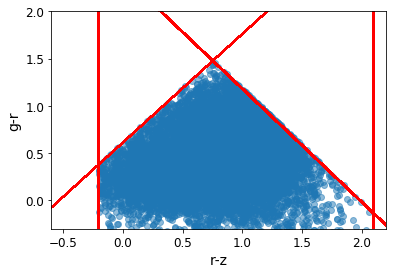

In [588]:
fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],'r--')
ax.plot(pad['x2'],pad['y2'],c='r',ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c='r',ls='--',lw=2)
ax.plot(pad['x4'],pad['y4'],c='r',ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

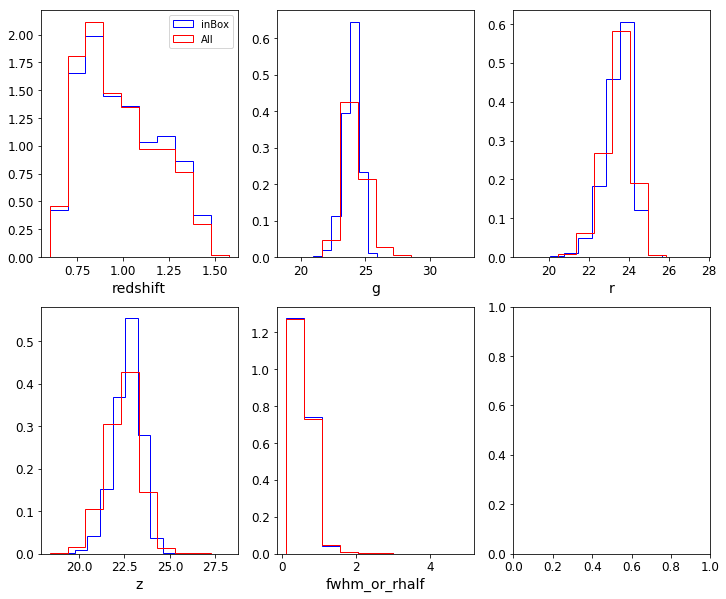

In [112]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()

## DEV have larger rhalf and are 1 mag brighter, however this is a small DEV sample so not sure if biased

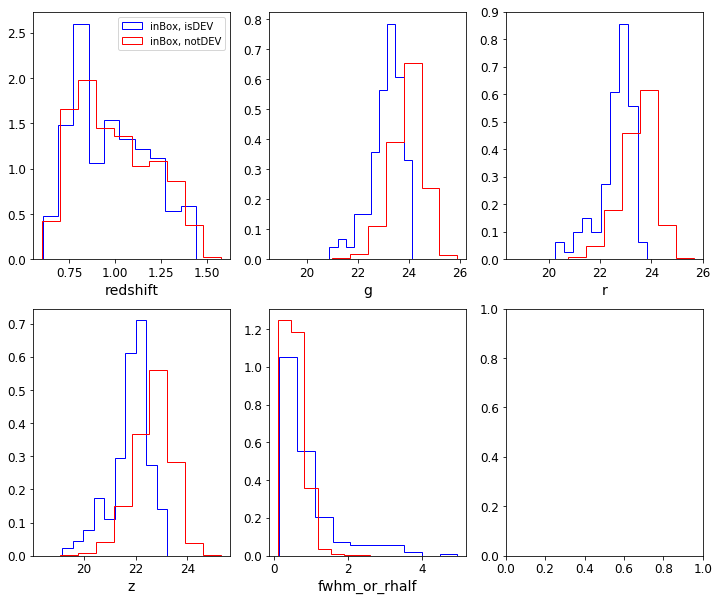

In [113]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[(inBox) & (isDEV),attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox, isDEV')
        _=ax[row,col].hist(df.loc[(inBox) & (~isDEV),attrs[i]],histtype='step',normed=True,
                           color='r',label='inBox, notDEV')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128365a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126857f60>]], dtype=object)

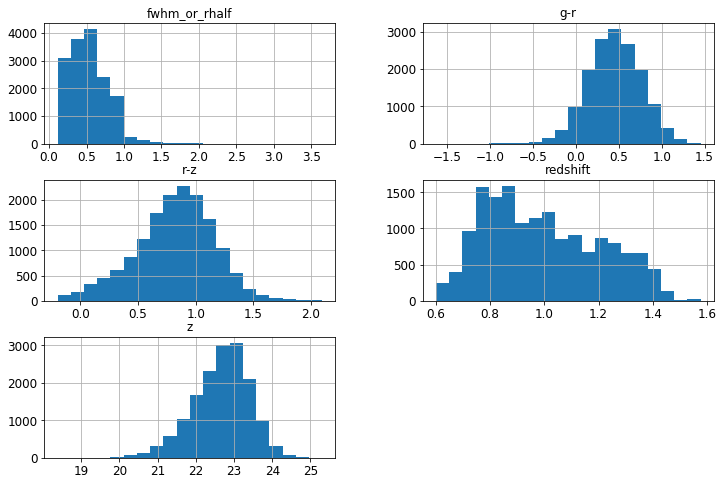

In [160]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_dev= df.loc[(inBox) & (isDEV),fit_cols]
df_notdev= df.loc[(inBox) & (~isDEV),fit_cols]
# Carry on with NOT DEV
df_notdev.hist(bins=20,figsize=(12,8))

14 components


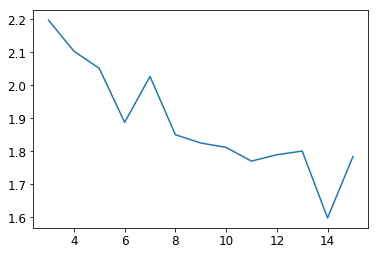

In [115]:
X= df_notdev.values
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

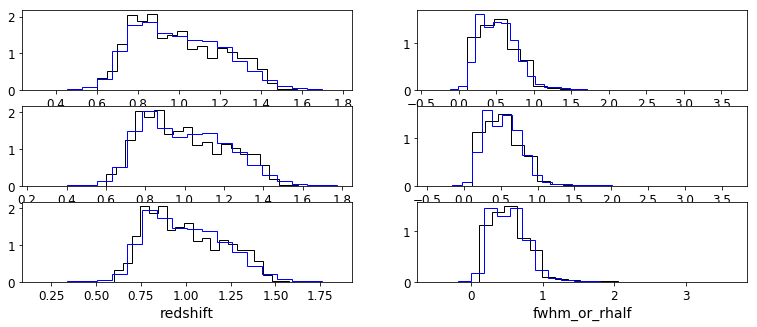

In [120]:
fig,ax= plt.subplots(3,2,figsize=(13,5))

for row,n in enumerate([8,10,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_notdev['redshift'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=20,histtype='step',color='b',normed=True)
    #ax[1].set_xlabel('redshift')

    _,bins,_= ax[row,1].hist(df_notdev['fwhm_or_rhalf'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,0],bins=20,histtype='step',color='b',normed=True)
    #ax[2].set_xlabel('fwhm_or_rhalf')
    
ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')

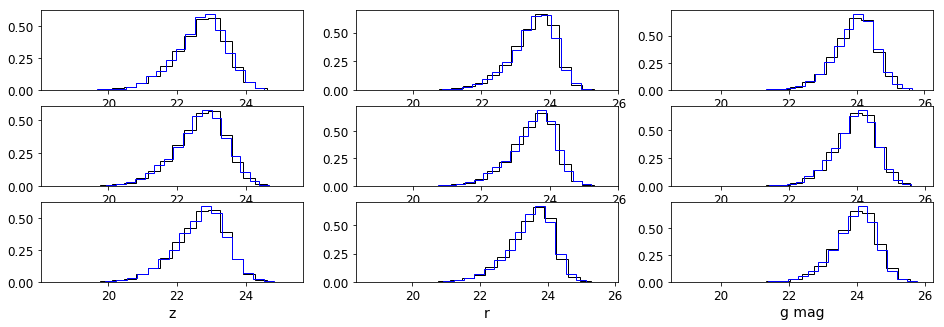

In [121]:
fig,ax= plt.subplots(3,3,figsize=(16,5))

for row,n in enumerate([8,10,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,1].hist(df_notdev['r-z']+df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,-3]+Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,2].hist(df_notdev['g-r'] + df_notdev['r-z']+df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,2].hist(Xpred[:,-4] + Xpred[:,-3] + Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)
    
ax[2,0].set_xlabel('z')
ax[2,1].set_xlabel('r')
ax[2,2].set_xlabel('g')

In [117]:
# smallest n_comp feel is ok, don't overfit!
gmm= gmms[np.where(n_comp == 8)[0][0]]
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)

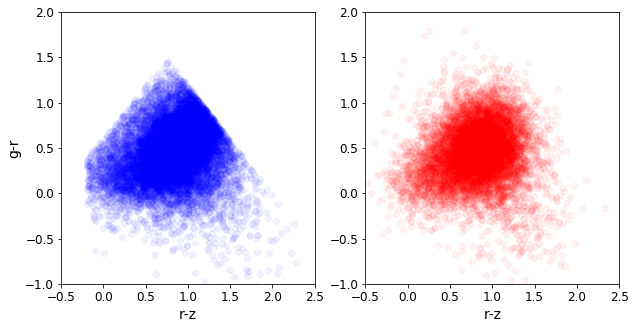

In [77]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_notdev['r-z'],df_notdev['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

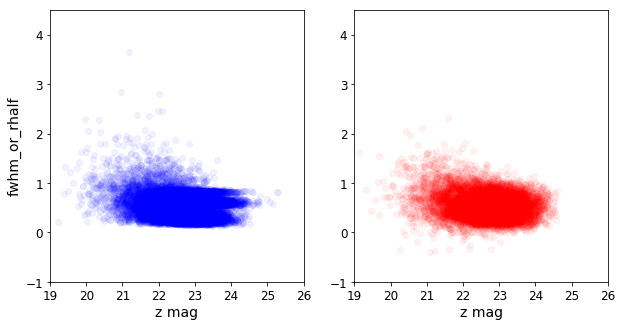

In [79]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_notdev['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)

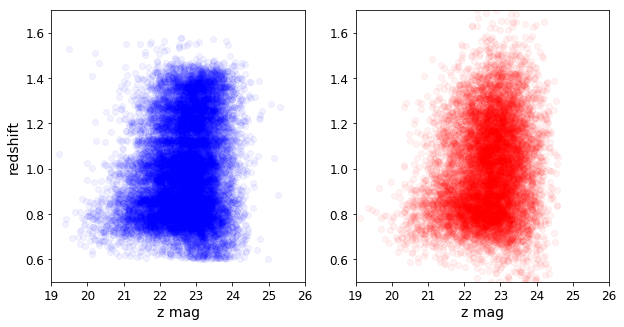

In [80]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_notdev['z'],df_notdev['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)

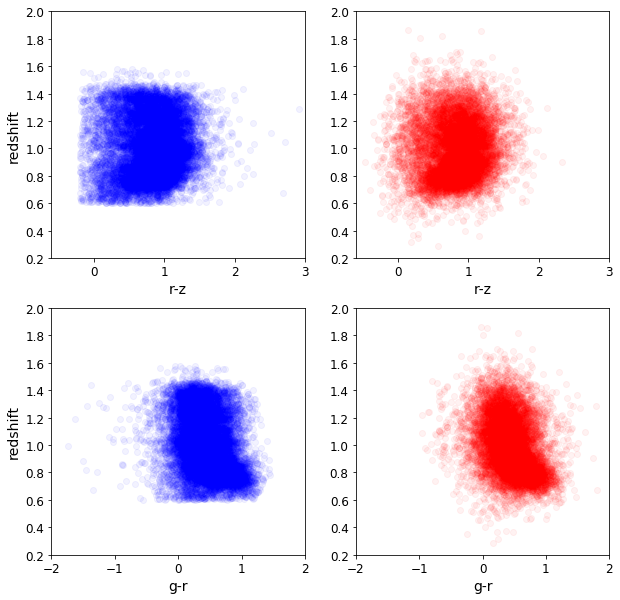

In [94]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_notdev['r-z'],df_notdev['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_notdev['g-r'],df_notdev['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')

count    15919.000000
mean         0.537243
std          0.271235
min          0.113250
25%          0.320844
50%          0.536520
75%          0.678899
max          4.954905
Name: fwhm_or_rhalf, dtype: float64

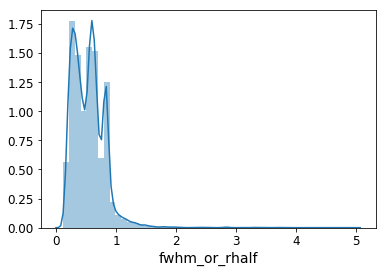

In [96]:
sns.distplot(df_new['fwhm_or_rhalf'])
df_new['fwhm_or_rhalf'].describe()

In [97]:
print(fit_cols)

['fwhm_or_rhalf', 'g-r', 'r-z', 'z', 'redshift']


## Resample until have 10k within redshift and rhalf limits

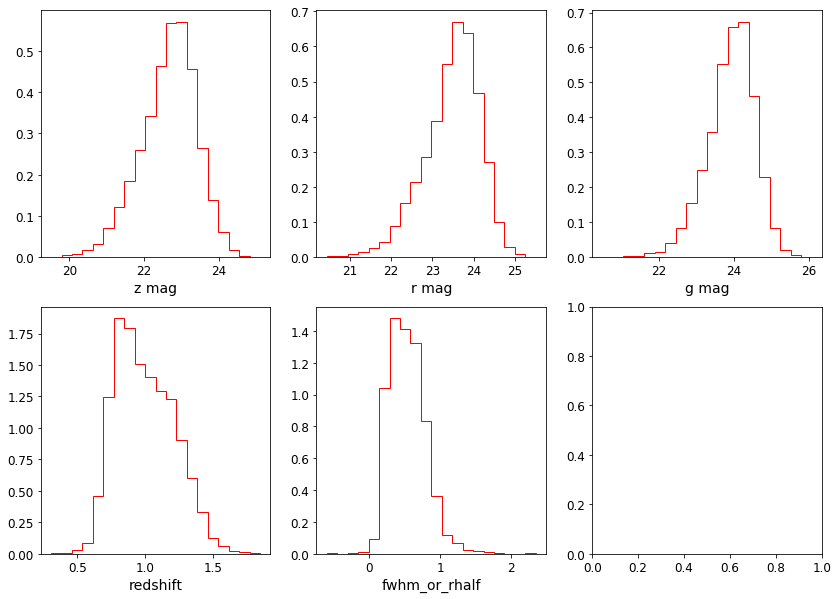

In [124]:
Xpred,Ypred= gmm.sample(10000)

fig,ax= plt.subplots(2,3,figsize=(14,10))

_=ax[0,0].hist(Xpred[:,3],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_=ax[0,1].hist(np.sum(Xpred[:,2:3+1],axis=1),bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_=ax[0,2].hist(np.sum(Xpred[:,1:3+1],axis=1),bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')

_=ax[1,0].hist(Xpred[:,-1],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('redshift')

_=ax[1,1].hist(Xpred[:,0],bins=20,histtype='step',color='r',normed=True)
ax[1,1].set_xlabel('fwhm_or_rhalf')

In [133]:
def ELGcuts(Xpred):
    """
    Args:
        Xpred: (N,5) array-like
            5 columns are: 
            fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
    """
    red_lim= (0.6,1.6) # DESI
    rhalf_lim= (0.262/2,2.) # Camera, Data
    g,r,z= tuple(np.array([24.0,23.4,22.5])+0.5)
    return ((Xpred[:,0] < rhalf_lim[0]) |
            (Xpred[:,0] > rhalf_lim[1]) |
            (Xpred[:,-1] < red_lim[0]) |
            (Xpred[:,-1] > red_lim[1]) |
            (Xpred[:,3] >= z) | #beyond mag limit
            (np.sum(Xpred[:,2:3+1],axis=1) >= r) |
            (np.sum(Xpred[:,1:3+1],axis=1) >= g)
            )

Xpred,Ypred= gmm.sample(10000)
i=0
outLimit= ELGcuts(Xpred)
num= len(Ypred[outLimit])
while num > 0:
    i+=1
    if i > 20:
        raise ValueError
    print(num)
    Xpred[outLimit,:],Ypred[outLimit]= gmm.sample(num)
    outLimit= ELGcuts(Xpred)
    num= len(Ypred[outLimit])

4345
1934
881
382
177
88
39
17
7
3
1
1
1


In [134]:
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_fin= pd.DataFrame(d)

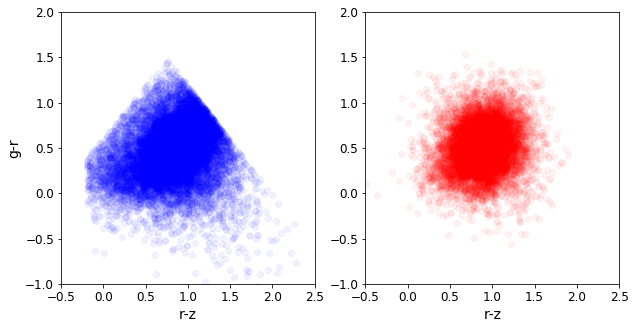

In [135]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_fin['r-z'],df_fin['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

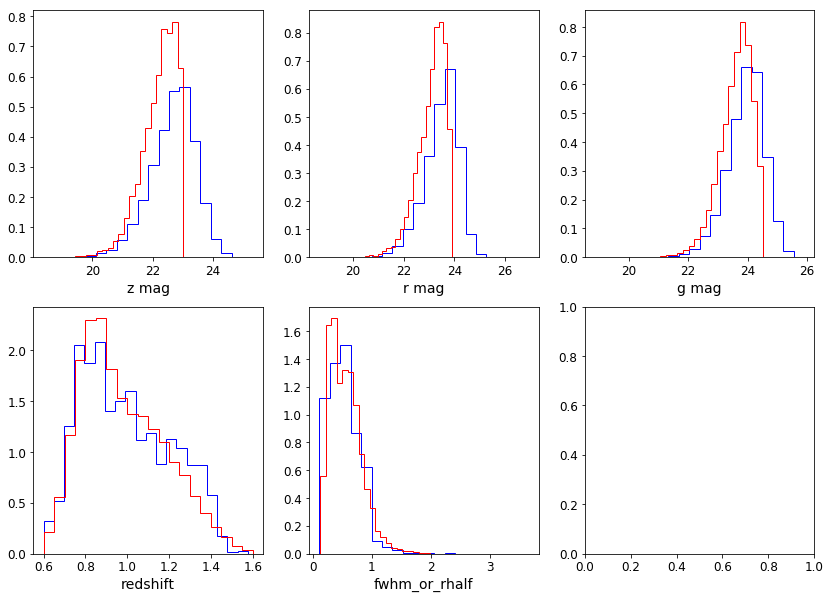

In [137]:
fig,ax= plt.subplots(2,3,figsize=(14,10))

_,bins,_= ax[0,0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,0].hist(df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_,bins,_= ax[0,1].hist(df_new['r-z']+df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,1].hist(df_fin['r-z']+df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_,bins,_= ax[0,2].hist(df_new['g-r']+df_new['r-z']+df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,2].hist(df_fin['g-r']+df_fin['r-z']+df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')


_,bins,_= ax[1,0].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1,0].hist(df_fin['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('redshift')

_,bins,_= ax[1,1].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[1,1].hist(df_fin['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[1,1].set_xlabel('fwhm_or_rhalf')

### Save the sample

In [138]:
df_fin.columns
a=fits_table()
a.set('id',np.arange(len(df_fin)))
a.set('rhalf',df_fin['fwhm_or_rhalf'].values)
a.set('redshift',df_fin['redshift'].values)
a.set('z',df_fin['z'].values)
a.set('r',df_fin['r-z'].values + a.z)
a.set('g',df_fin['g-r'].values + a.r)
a.writeto('elg_sample_5dim_10k.fits')

# Repeat for DEV
# Conclusion: not big enough DEV sample to extrapolate from OR fit MoG to

Training Size= 225
2 components


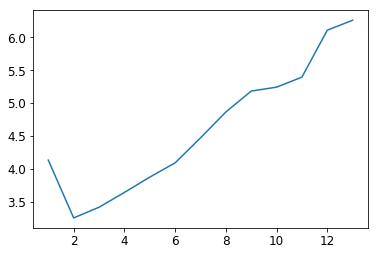

In [170]:
X= df_dev.values
print('Training Size=',X.shape[0])
gmms,i_min, n_comp, BICs= my_mixture(X,n_comp=np.arange(1,14))
plt.plot(n_comp,BICs)

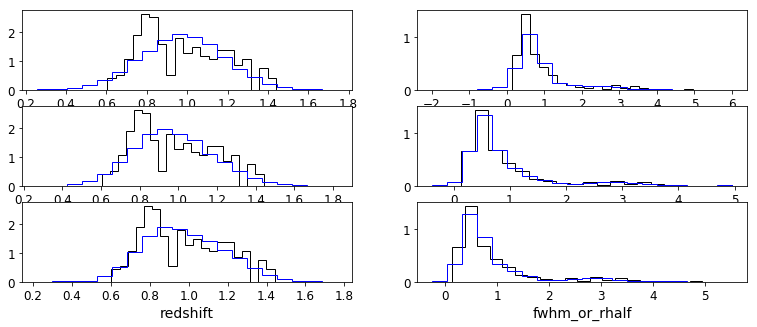

In [174]:
fig,ax= plt.subplots(3,2,figsize=(13,5))

for row,n in enumerate([2,6,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_dev['redshift'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=20,histtype='step',color='b',normed=True)
    #ax[1].set_xlabel('redshift')

    _,bins,_= ax[row,1].hist(df_dev['fwhm_or_rhalf'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,0],bins=20,histtype='step',color='b',normed=True)
    #ax[2].set_xlabel('fwhm_or_rhalf')
    
ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')

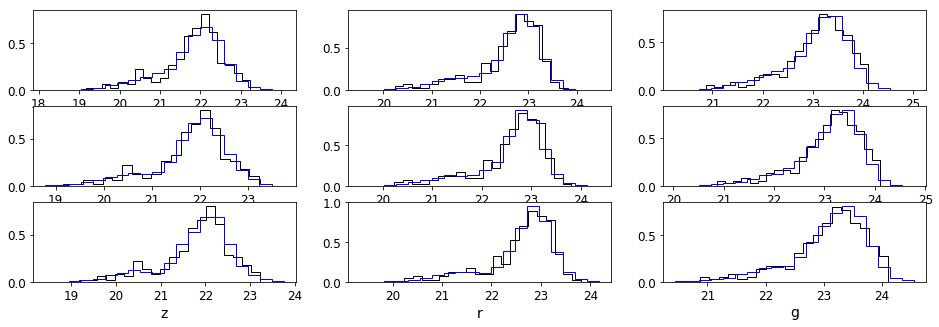

In [175]:
fig,ax= plt.subplots(3,3,figsize=(16,5))

for row,n in enumerate([2,6,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,1].hist(df_dev['r-z']+df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,-3]+Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,2].hist(df_dev['g-r'] + df_dev['r-z']+df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,2].hist(Xpred[:,-4] + Xpred[:,-3] + Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)
    
ax[2,0].set_xlabel('z')
ax[2,1].set_xlabel('r')
ax[2,2].set_xlabel('g')

# MoG to n(z) DESI

In [232]:
# random draws w/out replacement from sanches & kirkby n(z)
z1e5= fits_table(os.path.join(DATA_DIR,'sanchez_kirkby_z1e5.fits'))

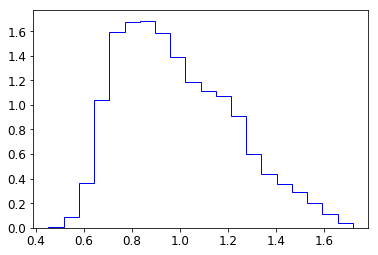

In [233]:
_=plt.hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)


4 components


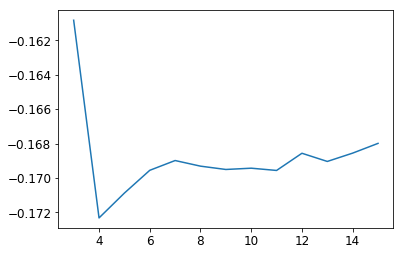

In [234]:
X= z1e5.z_cosmo.reshape(-1,1)
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

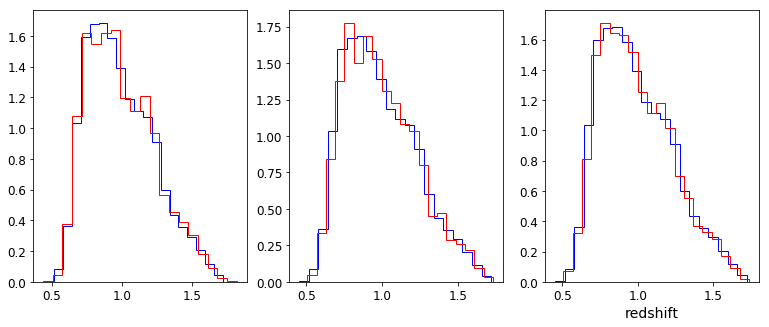

In [235]:
fig,ax= plt.subplots(1,3,figsize=(13,5))

for col,n in enumerate([4,8,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _=ax[col].hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)
    _=ax[col].hist(Xpred,bins=20,histtype='step',color='r',normed=True)
    
ax[2].set_xlabel('redshift')

## Intentionally overfit n(z)

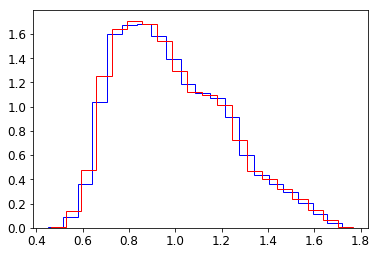

In [236]:
gmm= gmms[12]
z_pred,pdf_pred= gmm.sample(100000)
_=plt.hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=plt.hist(z_pred,bins=20,histtype='step',color='r',normed=True)

### Save model

In [290]:
np.arange(10).reshape(-1,1,1).shape

(10, 1, 1)

In [239]:
GaussianMixtureModel.save(gmm, filename='elg_nz', py='36')

Wrote elg_nz_means_36.txt
Wrote elg_nz_weights_36.txt
Wrote elg_nz_covars_36.txt


## Draw from n(z), match to 10k dr3-deep2 sample, plot redshift distribution of new dr3-deep2-nz sample

In [5]:
from scipy import spatial
sample_5d_10k=fits_table('elg_sample_5dim_10k.fits')
from obiwan.common import fits2pandas
sample_5d_10k= fits2pandas(sample_5d_10k)

tree = spatial.KDTree(sample_5d_10k['redshift'].values.reshape(-1,1))

In [253]:
gmm.covariances_.shape

(15, 1, 1)

In [9]:
model= GaussianMixtureModel.load(filename='elg_nz',py='36',is1D=True)

In [13]:
z= model.sample(1000)
_,ind= tree.query(z)
randoms= sample_5d_10k.iloc[ind]

print(len(sample_5d_10k),len(z),len(randoms))
print(randoms.columns), print(sample_5d_10k.columns)

(15,)
10000 1000 1000
Index(['g', 'id', 'r', 'redshift', 'rhalf', 'z'], dtype='object')
Index(['g', 'id', 'r', 'redshift', 'rhalf', 'z'], dtype='object')


(None, None)

In [18]:
for i in range(10):
    print(z[i],randoms['redshift'].iloc[i])

[ 1.17863478] 1.17876047504
[ 1.17322301] 1.17322153666
[ 1.1506008] 1.15054300718
[ 1.19767244] 1.19775757811
[ 1.19893259] 1.19892718065
[ 1.15093723] 1.15096243379
[ 1.15994011] 1.15990993527
[ 1.15066201] 1.15067316369
[ 1.13602797] 1.13600715492
[ 1.15877533] 1.1587258549


In [306]:
# Randoms table 
a=fits_table()
a.set('id',np.arange(len(randoms)))
a.set('id_5d10k_sample',randoms['id'].values) 
a.set('rhalf',randoms['rhalf'].values)
a.set('redshift',randoms['redshift'].values)
a.set('z',randoms['z'].values)
a.set('r',randoms['r'].values)
a.set('g',randoms['g'].values)
a.writeto('randoms_1.fits')

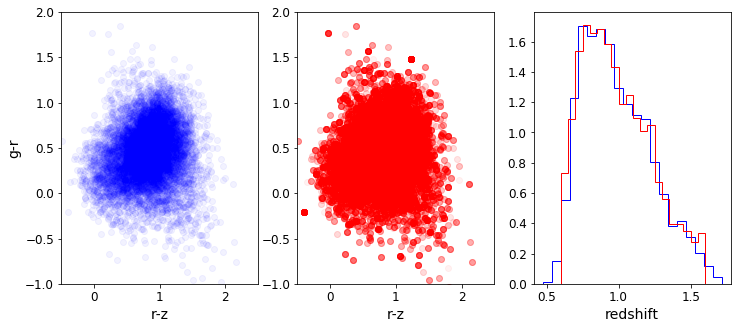

In [139]:
fig,ax= plt.subplots(1,3,figsize=(12,5))
ax[0].scatter(df_fin['r-z'],df_fin['g-r'],color='b',alpha=0.05)
ax[1].scatter(randoms['r-z'],randoms['g-r'],color='r',alpha=0.05)
_=ax[2].hist(z_10k.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(randoms['redshift'],bins=20,histtype='step',color='r',normed=True)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')
ax[2].set_xlabel('redshift')

## Fraction 10k sample in ELG TS box

In [8]:
tenk= fits_table('../../etc/elg_sample_5dim_10k.fits')

0.4201


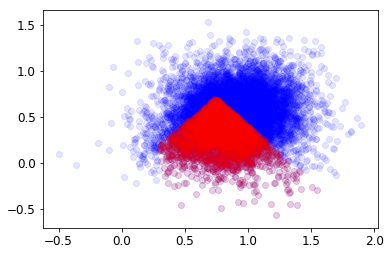

In [14]:
gr= tenk.g - tenk.r
rz= tenk.r - tenk.z
inBox= ((gr <= y1_line(rz)) &
        (gr <= y2_line(rz)) & 
        (rz >= 0.3) & 
        (rz <= 1.6))
plt.scatter(rz,gr,color='b',alpha=0.1)
plt.scatter(rz[inBox],gr[inBox],color='r',alpha=0.1)
print(len(rz[inBox])/float(len(rz)))

# eBOSS

In [17]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                                                                                             
print(dr3_fns,dp2_fns)

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)


['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-fi

In [18]:
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
notCOMP= dr3.type != 'COMP'
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= np.char.strip(dr3.type) == 'PSF'
isEXP= np.char.strip(dr3.type) == 'EXP'
isSIMP= np.char.strip(dr3.type) == 'SIMP'
isDEV= np.char.strip(dr3.type) == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r
dr3.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr3),len(dp2))
print(len(dr3[grz_gt0]), len(dr3[~notCOMP]))
print(len(dr3[fwhm_or_rhalf < 5]),len(dr3[complDP2_buff]))

print(set(dr3.type))
print(pd.Series(dr3.type).value_counts()/len(dr3))



28284 28284
27433 76
28265 23212
{'COMP', 'DEV', 'SIMP', 'EXP', 'PSF'}
PSF     0.440815
SIMP    0.335349
EXP     0.184557
DEV     0.036593
COMP    0.002687
dtype: float64


In [19]:
keep= ((grz_gt0) & 
       (notCOMP) & 
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr3.cut(keep)
dp2.cut(keep)
len(dr3)


d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr3.fwhm_or_rhalf
d['type']= dr3.get('type')
df= pd.DataFrame(d)

df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

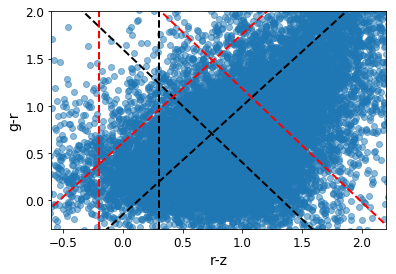

In [21]:
fig,ax=plt.subplots()
ax.scatter(df['r-z'],df['g-r'],alpha=0.5)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

rz= np.linspace(ax.get_xlim()[0],ax.get_xlim()[1])
gr= np.linspace(ax.get_ylim()[0],ax.get_ylim()[1])
nopad= get_ELG_box(rz,gr)
pad= get_ELG_box(rz,gr,pad=0.5)
for d,color in zip([nopad,pad],['k','r']):
    ax.plot(d['x1'],d['y1'],c=color,ls='--',lw=2)
    ax.plot(d['x2'],d['y2'],c=color,ls='--',lw=2)
    ax.plot(d['x3'],d['y3'],c=color,ls='--',lw=2)


(-0.6, 2.2)

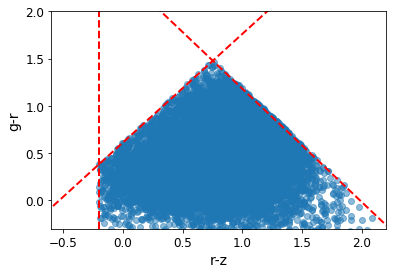

In [22]:
inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5))

fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],c=color,ls='--',lw=2)
ax.plot(pad['x2'],pad['y2'],c=color,ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c=color,ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)



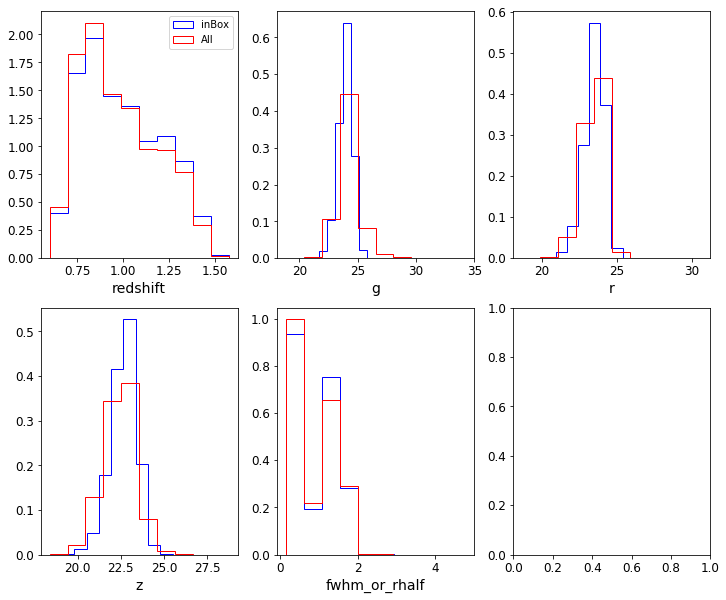

In [24]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117116ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1152b2eb8>]], dtype=object)

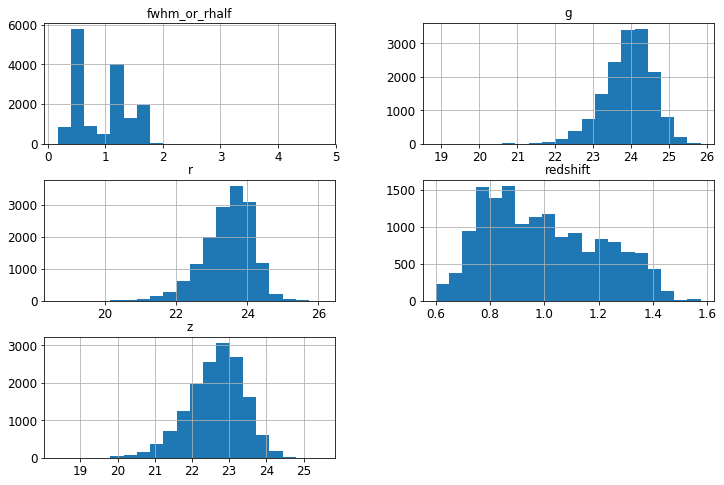

In [25]:
cols=['fwhm_or_rhalf', 'g', 'r', 'redshift', 'z']
df.loc[inBox,cols].hist(bins=20,figsize=(12,8))



14 components


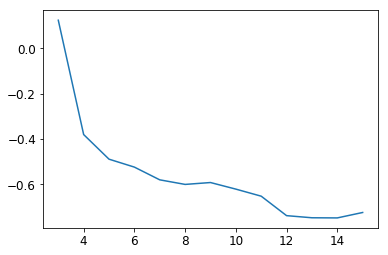

In [30]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_new= df.loc[inBox,fit_cols]

X= df_new.values
gmm, n_comp, BICs= my_mixture(X)
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

plt.plot(n_comp,BICs)



In [31]:
Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)





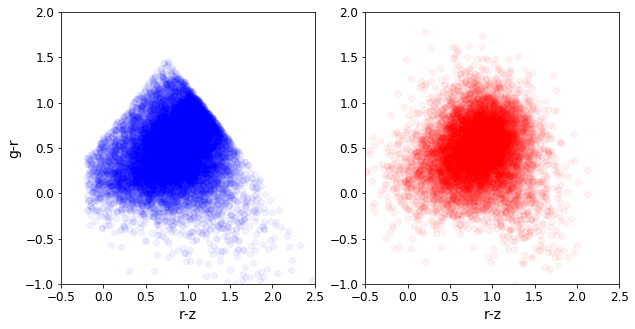

In [32]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')



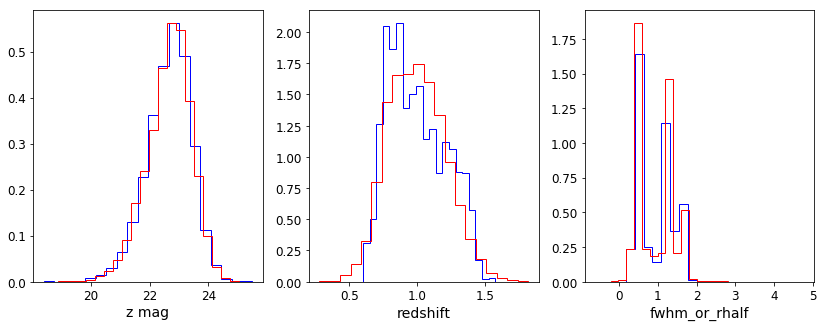

In [34]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')



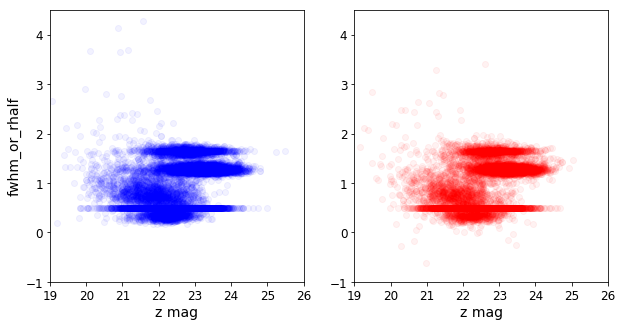

In [35]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)



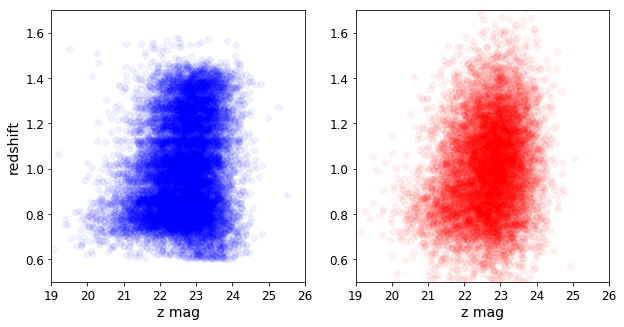

In [36]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)



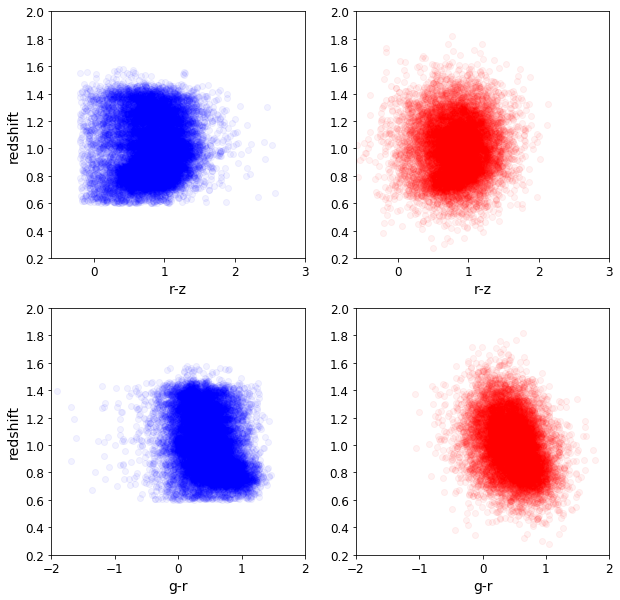

In [37]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_new['r-z'],df_new['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_new['g-r'],df_new['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')